In [281]:
#To run this code use environment: geo_env
#should take between 5-10min to run

import numpy as np 
import pandas as pd
from haversine import haversine_vector, Unit, haversine
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import sys
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import matplotlib.colors as mcolors
from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine
from sqlalchemy import text
import sqlite3
import os
from tqdm import tqdm
import seaborn as sns

State="NC"
StatesSHP="./InputData/US_State_Boundaries/us-state-boundaries.shp"

GeneratorDataPath="./InputData/EIAData/february_generator2023.xlsx"
HazusDataPath="./InputData/HazusData/Hazus_NC_Hurricane.shp"

UserDataPath="./InputData/ExcelUserData/"
CensusDataPath="./InputData/CensusData/US_tract_cenpop_2020.shp" # https://data2.nhgis.org/downloads

EIA_930_BalancePath="./InputData/EIAData/EIA-930-Balance/" # https://www.eia.gov/survey/#eia-930, Used for demand, ignore COVID years
EIA_930_CFPath="./InputData/EIAData/EIA-930-Generation/" # https://www.eia.gov/survey/#eia-930, Used for CFs include COVID years

EIA_923_Path="./InputData/EIAData/EIA923_Schedules_2_3_4_5_M_12_2021_Final_Revision.xlsx" # Fuel consumption and generation by plant
EIA_923_Path_2020="./InputData/EIAData/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx" # Fuel consumption and generation by plant

BiomassDataFromDOE_Path="./InputData/ExcelUserData/Biomass/billionton_state_download20230630-115258.csv" #Needs to be filtered for the State you are interesd

MajorBAs=["DUK", "CPLE"] #Major BA's in the region according to EIA-930 notation

SAM_NREL_Path="./InputData/NREL_SAM/"

HydroDataPath="./InputData/EIAData/ORNL_EHAHydroPlant_FY2020revised.xlsx" #most hydroplants in US with average generation and general data
NCAverageStatisticsPath="./InputData/EIAData/NC Energy Average Data Statistics EIA.xlsx" #NC average statistics from >2022 

FragilityCurvesDataPath="./InputData/FragilityCurvesData/" #Fragility curves for each type of building

sys.path.insert(0, './InputData/FragilityCurvesData/') #Fragility curves module
from fragility_curves import fragility

Vintages=np.arange(2022,1900,-1) #Exisiting years. [2022 to 2020), [2020 to 2018) Needs to start from earlier date to later date

#For us to set a limit in the CO2 emissions by 2050 we need the future years to go to 2055
#FutureYears=[2023]+list(np.arange(2025,2041,5))#2023 to 2056
FutureYears=[2023,2025,2030,2040,2050, 2055]



Seasons=["S1","S2","S3","S4"] # Winter, Spring, Summer, Fall
SeasonsMonthRange=[[12,1,2],[3,4,5],[6,7,8],[9,10,11]] #Months of each season [Start, End]
NumHoursSeason={"S1":90.25*24,"S2":92*24,"S3":92*24,"S4":91*24} #Number of hours in each season


TimeOfDay=["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T24"] # 24 hours of the day, cant be changed

UserScenario="Conservative" # (Conservative, Moderate, Advanced) from ATB cost perspectives
RegionsDefinition=["R1","R2","R3"]
RegionNotes=["East","Center","West"]

SaveSqlName="NC_EnergySystem2023"

# #Assign scenarios to the stochastic model
S2={"Name": "High Impact Hurricane",
    "HazusCodes": ["f200yr","f500yr","f1000yr"],
    "ProbPerYear":(1/200+1/500+1/1000),
    }

S1={"Name": "Medium Impact Hurricane",
    "HazusCodes":["f100yr","f50yr"],
    "ProbPerYear":(1/100+1/50),
    }

S0={"Name": "Low/No Impact Hurricane",
    "HazusCodes":["f10yr","f20yr"],
    "ProbPerYear": "1-S1-S2",
    }

Scenarios={"S0":S0,"S1":S1,"S2":S2}

#Assign scenarios to the stochastic model
# S1={"Name": "High Impact Hurricane",
#     "HazusCodes": ["f200yr","f500yr","f1000yr","f100yr"],
#     "ProbPerYear":(1/200+1/500+1/1000),
#     }

# S0={"Name": "Low/No Impact Hurricane",
#     "HazusCodes":["f10yr","f20yr","f50yr"],
#     "ProbPerYear": "1-S1-S2",
#     }

# Scenarios={"S0":S0,"S1":S1}

#Number of hours to represent in the model (sometime it is necessary to reduce the number of hours to control memory use in the stochastic model)
NumHoursAjust={"tm1":["T1","T2"],
                "tm2":["T3","T4"],
                "tm3":["T5","T6"],
                "tm4":["T7","T8"],
                "tm5":["T9","T10"],
                "tm6":["T11","T12"],
                "tm7":["T13","T14"],
                "tm8":["T15","T16"],
                "tm9":["T17","T18"],
                "tm10":["T19","T20"],
                "tm11":["T21","T22"],
                "tm12":["T23","T24"]}


#----- Tasks ------


#----- Extra Tasks (in progress need adjustments) ------
#1. Define transmission/distribution system costs for each region (Investment Fixed and Variable)
#   Need to verify Costs and existing capacity values - distribution is with no cost values and transmission/distribution is with no existing capacity values
                 
#----- Tasks next ------ P2

#Do later
#Interconnection transfers 
#Energy storage available on existing pumped hydro

#Percentage residential and commercial solar existing cap (https://www.seia.org/state-solar-policy/north-carolina-solar)

#----- Observations ------
#Storage 24h representative day, loop on the season instead the year

####################################-------------------------------------####################################
################## Important code modifications  :) ##################
####################################-------------------------------------####################################

#1. for Emission limit regions can be set as R1+R2+R3 where the sum of the emissions in all regions is limited by emis_limit
#Need to implement this in the temoa code (do it outside the stochatic model first on the  OEO model)
#2. Same problem of 1. with PlanningReserveMargin

#Min/Max activity or capacity for biomass and solar and wind
#Alternative biomass max at 2% of total demand independent of the period?

#3. Emission control biomass

# Code to Convert Excel Table to Sql data Part 1

## ExistingCapacity 


In [282]:
##Generation data from: Preliminary Monthly Electric Generator Inventory (based on Form EIA-860M as a supplement to Form EIA-860)

#Read File
df = pd.read_excel(GeneratorDataPath, sheet_name ='Operating',skiprows=2)
InState=df["Plant State"]==State #Filter for NC
df=df[InState].reset_index()

#NameplateCapacity should be larger than or equal to NetSummerCapacity and NetWinterCapacity
NC=df["Nameplate Capacity (MW)"]
NSC=df["Net Summer Capacity (MW)"]
NWC=df["Net Winter Capacity (MW)"]

df["Nameplate Capacity (MW)"]=np.max(np.vstack((NC,NSC,NWC)),axis=0)

In [283]:
#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
df.loc[df["Prime Mover Code"]=="CT","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CA","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CT","Technology"]="Combined cycle"
df.loc[df["Prime Mover Code"]=="CA","Technology"]="Combined cycle"

In [284]:
#   Some plants may have multiple generators commissioned at different times
#   we are aggregating the capacity of these generators per year

#   We can have multiple vintages (years) of the same plant. As generators may be comissioned at different times
df_AggregateGen = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "OperatingYear","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
 "NameplateEnergyCapacity(MWh)", "Latitude","Longitude","Technology"])

for ID in df["Plant ID"].unique().astype(int):
    #Same Plant data
    SameIds   = df["Plant ID"]==ID
    df_tmp1    = df[SameIds]

    SourceCode=df_tmp1["Energy Source Code"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["Energy Source Code"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["Prime Mover Code"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["Prime Mover Code"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]

            OperatingYear=df_tmp3["Operating Year"]
            OperatingYear=OperatingYear.sort_values(ascending=False)
            #Same Year Code data
            for UniqueY in OperatingYear.unique():
                
                SameIds    = df_tmp3["Operating Year"]==UniqueY
                df_tmp4    = df_tmp3[SameIds].reset_index()

                if UniqueMC!="BA":
                    NameplateEnergyCapacity=np.sum(df_tmp4["Nameplate Energy Capacity (MWh)"])
                    NameplateCapacity=np.sum(df_tmp4["Nameplate Capacity (MW)"])
                    NetSummerCapacity=np.sum(df_tmp4["Net Summer Capacity (MW)"])
                    NetWinterCapacity=np.sum(df_tmp4["Net Winter Capacity (MW)"])

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity, NetSummerCapacity, NetWinterCapacity,NameplateEnergyCapacity,
                    Latitude,Longitude,Technology]]

                    df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)
                else:
                    NameplateEnergyCapacity=df_tmp4["Nameplate Energy Capacity (MWh)"]
                    NameplateCapacity=df_tmp4["Nameplate Capacity (MW)"]
                    NetSummerCapacity=df_tmp4["Net Summer Capacity (MW)"]
                    NetWinterCapacity=df_tmp4["Net Winter Capacity (MW)"]

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    for k in range(len(df_tmp4)):
                        Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity.iloc[k], NetSummerCapacity.iloc[k], NetWinterCapacity.iloc[k],
                                NameplateEnergyCapacity.iloc[k],Latitude,Longitude,Technology]]

                        df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)                    

#Delete technologies that are after the maximum vintage period
df_AggregateGen=df_AggregateGen[df_AggregateGen["OperatingYear"]<=np.max(Vintages)]

#Check for missing data
if sum(df_AggregateGen[df_AggregateGen["MoverCode"]=="BA"]["NameplateEnergyCapacity(MWh)"]==' '):
    EliminateIdx=(df_AggregateGen["MoverCode"]=="BA") * (df_AggregateGen["NameplateEnergyCapacity(MWh)"]==' ')
    EliminateId=df_AggregateGen[EliminateIdx]["PlantID"]
    print("Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:\n Plant ID:")
    [print(EliminateId.iloc[i]) for i in range(EliminateId.shape[0])]

    df_AggregateGen=df_AggregateGen[~EliminateIdx]

df_AggregateGen = df_AggregateGen.reset_index(drop=True)

df_AggregateGen.to_excel(UserDataPath+"Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv1.xlsx")

Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:
 Plant ID:
MWH_BA_64640


### Aggregate per region

In [285]:
#Create regions of interest based on the Hazus data and aggregate the capacity of the generators in each region

shapefile_Hazus = gpd.read_file(HazusDataPath)
Hazus1000=shapefile_Hazus.f1000yr

#Define regions of interest
Region1Idx=Hazus1000>=130 # Cat 4 hurricane and above 130mph
Region2Idx=(Hazus1000>=111)*(Hazus1000<130) # Cat 3 hurricane 111-129mph
Region3Idx=Hazus1000<111 # Cat 1-2 hurricane and bellow 110mph

Region1Data=shapefile_Hazus[Region1Idx].reset_index()
Region2Data=shapefile_Hazus[Region2Idx].reset_index() 
Region3Data=shapefile_Hazus[Region3Idx].reset_index()     

new_polyR1 = unary_union([Region1Data.iloc[j]["geometry"] for j in range(Region1Data.shape[0])])
new_polyR2 = unary_union([Region2Data.iloc[j]["geometry"] for j in range(Region2Data.shape[0])])
new_polyR3 = unary_union([Region3Data.iloc[j]["geometry"] for j in range(Region3Data.shape[0])])

df_AggregateGen["Region"]=''
#Assign region for each generation 

for i in range(df_AggregateGen.shape[0]):
    Latitude=df_AggregateGen.iloc[i]["Latitude"]
    Longitude=df_AggregateGen.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R3'

    else:
        print("Error")
        break

if sum(df_AggregateGen.Region=='')==0:
    print("All existing generators were properly mapped")
else:
    print("Some generators were no properly mapped to the Hazus data\
    check Hazus and the location of generators")

df_AggregateGen3 = pd.DataFrame(columns=["PlantID", "SourceCode", "MoverCode", "Vintage","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
"NameplateEnergyCapacity(MWh)","Technology","Region"])


for Region in ["R1","R2","R3"]:

    df_tmp1=df_AggregateGen[df_AggregateGen["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            OperatingYear=df_tmp3["OperatingYear"]
            for i in range(len(Vintages[0:-1])):

                IdxsIn=(OperatingYear<=Vintages[i]+(Vintages[0]-Vintages[1])/2) * (OperatingYear>Vintages[i]-(Vintages[0]-Vintages[1])/2)
                if sum(IdxsIn)!=0:
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn].reset_index()    

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        NameplateEnergyCapacity=np.sum(df_tmp4["NameplateEnergyCapacity(MWh)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC
                        Technology= df_tmp4["Technology"].iloc[0]

                        Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                        Technology,Region]]

                        df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)
                    else:
                        #We need to differentiate between the different battery technologies
                        #Consider 1, 2 ,4, 6, 8 ,10h battery
                        df_tmp4=df_tmp3[IdxsIn].reset_index()    
                        HoursOfOperation=df_tmp4["NameplateEnergyCapacity(MWh)"]/df_tmp4["NameplateCapacity(MW)"] #h operation of each battery


                        TmpBrack=[0, 1, 2 ,4, 6, 8 ,10]
                        for h_id in range(len(TmpBrack)):
                            
                            IdxInBatteryH= (HoursOfOperation>TmpBrack[i]) * (HoursOfOperation<=TmpBrack[i+1])
                            df_tmp5=df_tmp4[IdxInBatteryH].reset_index()    
                            #if not empty
                            if sum(IdxInBatteryH)!=0:
                                
                                #Need to ajust the power of the battery to match the energy capacity
                                NameplateCapacity=np.sum(df_tmp5["NameplateEnergyCapacity(MWh)"])/TmpBrack[i+1]
                                NetSummerCapacity=NameplateCapacity
                                NetWinterCapacity=NameplateCapacity
                                NameplateEnergyCapacity=TmpBrack[i+1]*NameplateCapacity
                                
                                NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC +str(TmpBrack[i+1])+"H"
                                Technology= df_tmp5["Technology"].iloc[0]

                                Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                                NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                                Technology,Region]]

                                df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)                                

dfExistingCapacity=df_AggregateGen3

All existing generators were properly mapped


### Area of Each Region

In [286]:
PercentageAreaR1=new_polyR1.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)
PercentageAreaR2=new_polyR2.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)
PercentageAreaR3=new_polyR3.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)

### Plot regions and tech location

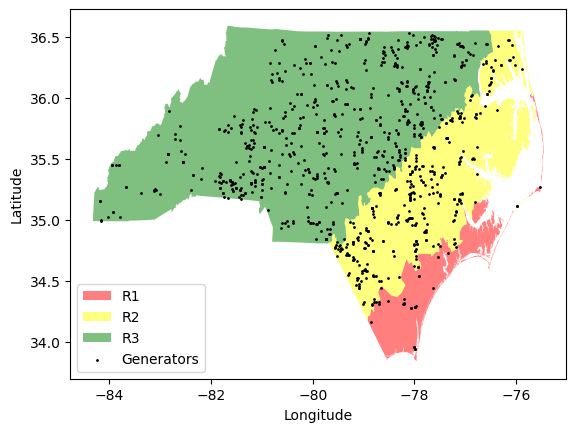

In [287]:
fig, ax = plt.subplots()

count=0
for geom in new_polyR1.geoms:    
    xs, ys = geom.exterior.xy    
    count=count+1
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none',label="R1")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

count=0
for geom in new_polyR2.geoms:    
    count=count+1
    xs, ys = geom.exterior.xy    
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none',label="R2")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none')


xs, ys = new_polyR3.exterior.xy    
ax.fill(xs, ys, alpha=0.5, fc='green', ec='none',label="R3")


plt.scatter(df_AggregateGen["Longitude"],df_AggregateGen["Latitude"],color="black",s=1, label="Generators")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("OutputData/Figures/RegionsByRisk.png")


### Write df on sql format

In [288]:
ExistingCapacity_sql = pd.DataFrame(columns=["regions", "tech", "vintage", "exist_cap", "exist_cap_units", "exist_cap_notes"])
ExistingCapacity_sql["regions"]=dfExistingCapacity["Region"]
ExistingCapacity_sql["tech"]=dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')


ExistingCapacity_sql["vintage"]=dfExistingCapacity["Vintage"]
ExistingCapacity_sql["exist_cap"]=dfExistingCapacity["NameplateCapacity(MW)"]/1000 #MW to GW
ExistingCapacity_sql["exist_cap_units"]="GW"
ExistingCapacity_sql["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"

In [289]:
#Export unique tech name and description to facilitate the manual mapping
data1=ExistingCapacity_sql["tech"].unique()
data2=[dfExistingCapacity[ dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')==tech]["Technology"].iloc[0] for tech in ExistingCapacity_sql["tech"].unique()]

ExistingCapacity_sql["tech"]=ExistingCapacity_sql["tech"]+"_EXISTING"
data1=data1+"_EXISTING"
data=zip(data1,data2)

ExistingCapacity_UniqueTechNamedf=pd.DataFrame(columns=["tech","description"],data=data)
ExistingCapacity_UniqueTechNamedf.to_excel(UserDataPath + "Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv2.xlsx",index=False)

### Plot Existing Capacity by Operating Year

In [290]:
#Get colors for each tech plot
def GetColors(Tech):
    Colors=[]
    ColorsUser= pd.read_excel(UserDataPath+"UserDataPart3.xlsx", sheet_name ='TechColor')

    for t in Tech:
        pallet=ColorsUser.loc[ColorsUser["Tech"]==t,"Pallet"].values[0]
        idx=ColorsUser.loc[ColorsUser["Tech"]==t,"Idx"].values[0]
        Colors.append(sns.color_palette(pallet, n_colors=20)[idx])

    return Colors

In [291]:
def PlotStackBars(Data, ExcludeTech=["TRANSMISSION_REGIONAL","DISTRIBUTION"],DataColumn="vintage",TechTermination="_EXISTING",Regions=["R1","R2","R3"],X_name="Vintage",Y_name="Capacity [GW]",scale_legend=1000, ScaleUnits="MW",
                  Title="Existing Capacity", OutputName="ExistingCapacity",Ticks=1):

    #Filter for selected regions and technology terminations and eliminate excluded technologies
    df_tmp=Data[Data["regions"].isin(Regions)]  #Exclude regions
    df_tmp=df_tmp[~df_tmp["tech"].isin(ExcludeTech)]#Exclude technologies
    df_tmp=df_tmp[df_tmp["tech"].str.contains(TechTermination)] #Filter for technology termination
    df_tmp=df_tmp.sort_values(by=['tech'])

    Units=df_tmp["exist_cap_units"].values[0]

    #Sum Data by Tech and Vintage
    df_tmp_G=df_tmp.groupby(["tech",DataColumn]).sum().reset_index()

    #Plot stacked tech bars for each vintage
    df_pivot=df_tmp_G.pivot(index=DataColumn,columns='tech',values='exist_cap')
    fig, ax = plt.subplots()

    #Choose from a large pallet of collors and plot
    Tech=df_pivot.columns.values
    colors =GetColors(Tech)

    #Add total "capacity" to the legend
    Legend=Tech.tolist()
    TotalCapacity=df_tmp_G.groupby(["tech"]).sum().reset_index()
    TotalCapacity=(TotalCapacity["exist_cap"]*scale_legend).astype(float).round(1).astype(str).values.tolist()
    Legend=[Legend[i]+" ("+TotalCapacity[i]+ScaleUnits+")" for i in range(len(Legend))]
    df_pivot.plot.bar(stacked=True,ax=ax,color=colors,legend=False)
    ax.legend(Legend,loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)

    ax.set_ylabel(Y_name)
    ax.set_xlabel(X_name)
    ax.set_title(Title)

    UniqueYears=df_tmp[DataColumn].unique()
    MaxY=UniqueYears.max()
    MinY=UniqueYears.min()


    # step=int((MaxY-MinY+1)/25)
    # if step>1:
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))

    #Enlongate the graph horizontally
    fig.set_size_inches(10, 5)

    plt.savefig("OutputData/Figures/"+OutputName+".png",dpi=1000, bbox_inches='tight')
    plt.show()

    return fig


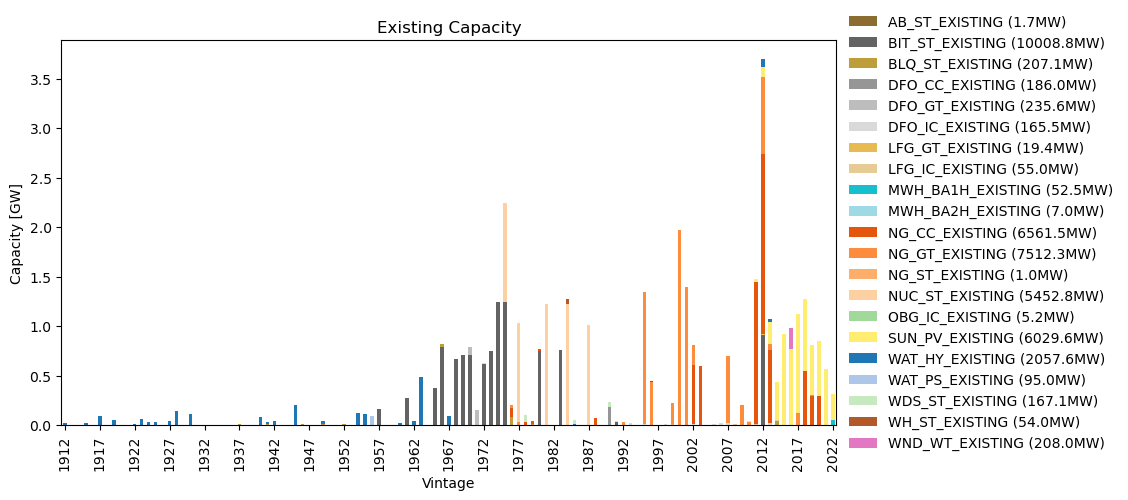

In [292]:
Data=ExistingCapacity_sql.copy()
#Add zero values for all vintages to make sure the ticks on the plot are correct
tech="BLQ_ST_EXISTING"
MaxVintage=Data["vintage"].unique().max()
MinVintage=Data["vintage"].unique().min()
for vintage in range(MinVintage,MaxVintage+1,1):
    Data=pd.concat([Data,pd.DataFrame({"regions":"R1","tech":tech,"vintage":vintage,"exist_cap":0,"exist_cap_units":"GW","exist_cap_notes":"EIA 860 Generator + Code 2 aggregate"},index=[0])],ignore_index=True)

_=PlotStackBars(Data)

## LifetimeTech & LifetimeLoanTech

### Get Average Lifetime from EIA 860 Form

In [293]:
#Read File
df = pd.read_excel(GeneratorDataPath, sheet_name ='Retired',skiprows=2)
df=df[df["Nameplate Capacity (MW)"]>=0]

# StatesInside=["AL","AK","AZ","AR","CA","CO","CT","DE","DC","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",
# "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN",
# "TX","UT","VT","VA","WA","WV","WI","WY"]
#StatesInside=["ME","NH","MA","RI","CT","NY","NJ","DE","MD","VA","NC","SC","GA","FL"]
StatesInside=["NC"] #If Capacity >100MW use NC othrewise east coast
InState=df["Plant State"].isin(StatesInside) #Filter for South 
df=df[InState].reset_index()

#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
df.loc[df["Prime Mover Code"]=="CT","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CA","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CT","Technology"]="Combined cycle"
df.loc[df["Prime Mover Code"]=="CA","Technology"]="Combined cycle"
df["LifetimeWC"]=(df["Retirement Year"]-df["Operating Year"]+1)*df["Nameplate Capacity (MW)"]

#Get average Lifetime. Group by Energy source and Prime mover
df_Lifetime=df.groupby(["Energy Source Code","Prime Mover Code"])[["LifetimeWC","Nameplate Capacity (MW)"]].sum().reset_index()
df_Lifetime["Lifetime"]=df_Lifetime["LifetimeWC"]/df_Lifetime["Nameplate Capacity (MW)"]

#pd.set_option('display.max_rows', None)
df_Lifetime
# pd.reset_option('display.max_rows')

,Energy Source Code,Prime Mover Code,LifetimeWC,Nameplate Capacity (MW),Lifetime
0,BIT,ST,248292.4,4559.0,54.462031
1,BLQ,ST,4388.7,79.7,55.065245
2,DFO,CC,5937.0,102.0,58.205882
3,DFO,GT,12328.0,277.5,44.425225
4,DFO,IC,257.2,20.0,12.860000
5,LFG,FC,99.5,10.5,9.476190
6,LFG,GT,99.0,4.5,22.000000
7,LFG,IC,131.9,12.8,10.304688
8,MSW,ST,176.0,14.6,12.054795
9,NG,GT,14811.6,337.4,43.899229


### Get Energy Capacity With Specific Retirement Dates

In [294]:
#Read File
df_Retirement = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='LifeTimeSpecific')

#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
df_Retirement.loc[df_Retirement["MoverCode"]=="CT","MoverCode"]="CC"
df_Retirement.loc[df_Retirement["MoverCode"]=="CA","MoverCode"]="CC"

for i in range(df_Retirement.shape[0]):
    Latitude=df_Retirement.iloc[i]["Latitude"]
    Longitude=df_Retirement.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R3'

    else:
        print("Error")
        break
df_Retirement["tech"]=df_Retirement["SourceCode"]+"_"+df_Retirement["MoverCode"] + "_EXISTING"

In [295]:
#Aggregate the retirement data (df_AggregateRetirement)
df_AggregateRetirement = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "RetireYear", "NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)", "Region"])

for Region in ["R1","R2","R3"]:

    df_tmp1=df_Retirement[df_Retirement["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            RetireYear=df_tmp3["RetireYear"]
            for RefRetireYear in RetireYear.unique():

                IdxsIn=df_tmp3["RetireYear"]==RefRetireYear
                if sum(IdxsIn)!=0:
                    #So far only considering data for non BA technology
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn]

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC + "_EXISTING"


                        Data=[[NewPlantID, UniqueSC, UniqueMC, RefRetireYear,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity,Region]]

                        df_AggregateRetirement=pd.concat([df_AggregateRetirement,pd.DataFrame(Data,columns=df_AggregateRetirement.columns)],ignore_index=True)
                        

### Build a sql for the LifetimeTech & LifetimeLoanTech

In [296]:
#Read File
df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='LifeTimesLoanTechDefault')

LifetimeTech_sql = pd.DataFrame(columns=["Regions","tech", "life", "life_notes"])
LifetimeLoanTech_sql = pd.DataFrame(columns=["Regions","tech", "loan", "loan_notes"])


Regions=["R1"]*len(df)+["R2"]*len(df)+["R3"]*len(df)
tech=np.tile(df["tech"],3)
life=np.tile(df["life tech"],3)
loan=np.tile(df["loan"],3)
Observations=np.tile(df["Observations"],3)

LifetimeTech_sql["Regions"]=Regions
LifetimeTech_sql["tech"]=tech
LifetimeTech_sql["life"]=life
LifetimeTech_sql["life_notes"]=Observations

LifetimeLoanTech_sql["Regions"]=Regions
LifetimeLoanTech_sql["tech"]=tech
LifetimeLoanTech_sql["loan"]=loan
LifetimeLoanTech_sql["loan_notes"]=Observations

## ExistingCapacity Changes to Match Known Retirements

In [297]:
# Change the operation year and allocate capacity to match known retirements and LifetimeTech
# On temoa there is only one LifetimeTech value per technology. Since we grouped the technologies part of it 
# may retire at different times. We only know the expected retirements for a few generators (~60%) we need to make sure retirements happen at the right time
ExistingCapacity_sql_adjusted = ExistingCapacity_sql.copy()

for i in range(df_Retirement.shape[0]):
    #Retirement data
    OperatingYear=df_Retirement.iloc[i]["OperatingYear"]
    RetireYear=df_Retirement.iloc[i]["RetireYear"]

    Region=df_Retirement.iloc[i]["Region"]
    SourceCode=df_Retirement.iloc[i]["SourceCode"]
    MoverCode=df_Retirement.iloc[i]["MoverCode"]
    tech=df_Retirement.iloc[i]["tech"]
    NameplateCapacity=df_Retirement.iloc[i]["NameplateCapacity(MW)"]/1000 #MW to GW
    NetSummerCapacity=df_Retirement.iloc[i]["NetSummerCapacity(MW)"]/1000 #MW to GW
    NetWinterCapacity=df_Retirement.iloc[i]["NetWinterCapacity(MW)"]/1000 #MW to GW

    #Defined in the sql file is the same for all tehcnologies of the same type
    LifeOfTech=LifetimeTech_sql[(LifetimeTech_sql["tech"]==tech) * (LifetimeTech_sql["Regions"]==Region)]["life"].iloc[0]

    #Check for tech and regions that are the same
    IdxCandidate= (ExistingCapacity_sql["regions"]==Region) * (ExistingCapacity_sql["tech"]==tech)
    
    if sum(IdxCandidate)!=0:
        
        #Check for years that are the same of very close
        Targets=(ExistingCapacity_sql[IdxCandidate]["vintage"]-OperatingYear).abs()
        EC_Av_Discount=np.sum(ExistingCapacity_sql[IdxCandidate]["exist_cap"][Targets==0]) #Existing capacity available for discount
        
        if EC_Av_Discount>=NameplateCapacity: #a buffer of 0 years between retirements and existing capacity is allowed (change Targets==0 to Targets<=1 to allow for a 1 year buffer)            
            NewVintageLocation=RetireYear-LifeOfTech #Year that the resource should be placed to match retirements
            if NewVintageLocation>=FutureYears[0]:
                print("Inconsistency between retirements and existing capacity.\nLikely lifetimes too small for the target retirements, and/or need to separate technologies with different lifetimes")
                #ignore this error as the differences are small only a few years for some technologies with retirement >2050
                print("On Retirement Info: Tech (%s)  NewVintage (%s) Retirement (%s) NameplateCapacity (%s)"%(tech,NewVintageLocation,RetireYear,NameplateCapacity))
                print("Error of %s years"%(NewVintageLocation-Vintages[0]))
                if NewVintageLocation>=FutureYears[1]:
                    print("Fix the inconsistency or increase relaxation for the error, by setting FutureYears[2,3,..]")
                    break
                print("Ignoring the inconsistency as it seems to be small\n\n")
                NewVintageLocation=Vintages[0] #Since the year need to be larger than Vintages[0] for adequeate retirement we set it to Vintages[0] and ignore the error
            #add
            else:
                Data=[[Region,tech, NewVintageLocation, NameplateCapacity, "GW", "New add for retirement ballance"]]
                ExistingCapacity_sql_adjusted=pd.concat([ExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=ExistingCapacity_sql.columns)],ignore_index=True) 

                #subtract
                Data=[[Region,tech, OperatingYear, -NameplateCapacity, "GW", "New add for retirement ballance"]]
                ExistingCapacity_sql_adjusted=pd.concat([ExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=ExistingCapacity_sql.columns)],ignore_index=True)            

        else:
            print("Error- Inconsistency between retirements and existing capacity. Not enought capacity on the EIA 860 forms for the target retire")
            print("On Retirement Info: Tech (%s)  OperatingYear (%s)  NameplateCapacity (%s)"%(tech,OperatingYear,NameplateCapacity))
            break


Inconsistency between retirements and existing capacity.
Likely lifetimes too small for the target retirements, and/or need to separate technologies with different lifetimes
On Retirement Info: Tech (NG_CC_EXISTING)  NewVintage (2023) Retirement (2060) NameplateCapacity (0.19119999999999998)
Error of 1 years
Ignoring the inconsistency as it seems to be small


Inconsistency between retirements and existing capacity.
Likely lifetimes too small for the target retirements, and/or need to separate technologies with different lifetimes
On Retirement Info: Tech (NG_CC_EXISTING)  NewVintage (2023) Retirement (2060) NameplateCapacity (0.1028)
Error of 1 years
Ignoring the inconsistency as it seems to be small


Inconsistency between retirements and existing capacity.
Likely lifetimes too small for the target retirements, and/or need to separate technologies with different lifetimes
On Retirement Info: Tech (NG_CC_EXISTING)  NewVintage (2023) Retirement (2060) NameplateCapacity (0.1911999999999

In [298]:
ExistingCapacity_sql_adjusted_tmp=ExistingCapacity_sql_adjusted.groupby(["regions","tech","vintage"])["exist_cap"].sum().reset_index()
ExistingCapacity_sql_adjusted_tmp["exist_cap_units"]="GW"
ExistingCapacity_sql_adjusted_tmp["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"

#Check for negative values
#pop error
if np.sum(ExistingCapacity_sql_adjusted_tmp[ExistingCapacity_sql_adjusted_tmp["exist_cap"]<0]["exist_cap"])<=-1/1000: #1MW of inconsistency:
    print("Error- Inconsistency between retirements and existing capacity. Negative values existing capacity")
else:
    ExistingCapacity_sql_adjusted_tmp=ExistingCapacity_sql_adjusted_tmp[ExistingCapacity_sql_adjusted_tmp["exist_cap"]>0]
    ExistingCapacity_sql_adjusted=ExistingCapacity_sql_adjusted_tmp
    print("Known retirements properly allocated to existing capacity.")

#ExistingCapacity_sql_adjusted: corrected ExistingCapacityValues

Known retirements properly allocated to existing capacity.


### Print Retirements

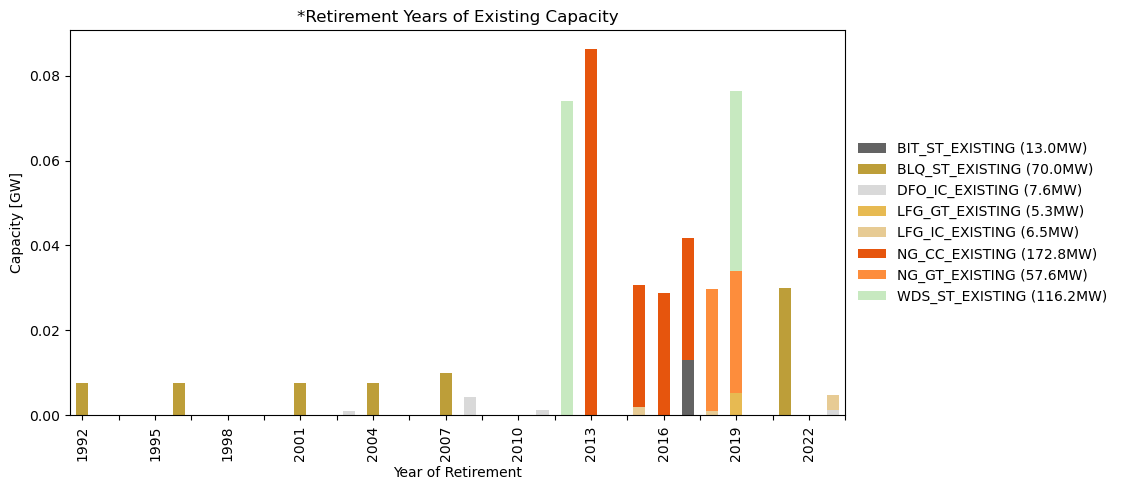

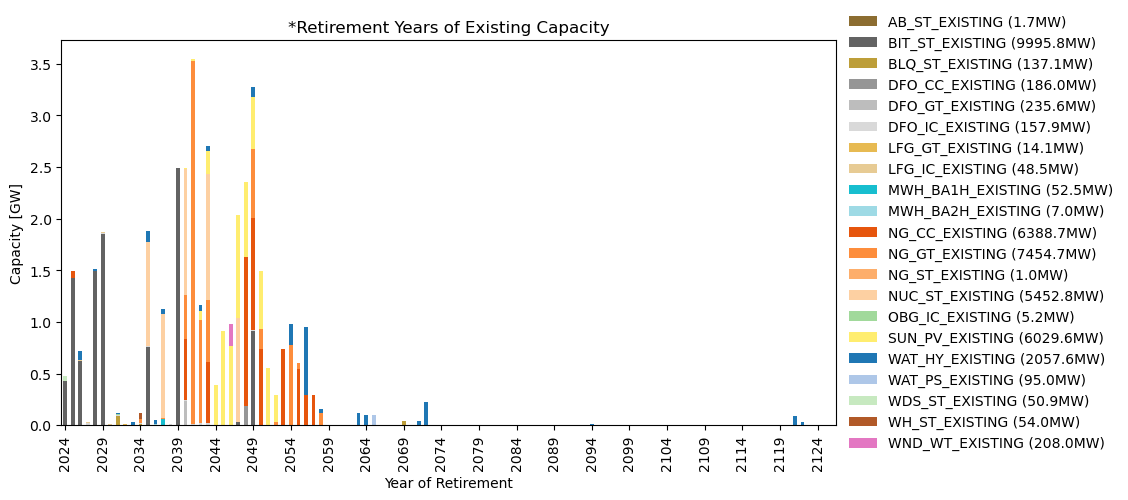

In [299]:
Data=ExistingCapacity_sql_adjusted.copy().reset_index(drop=True)
#Compute retirement year
Data["RetireYear"]=0
for i in range(len(Data)):
    Life=LifetimeTech_sql[LifetimeTech_sql["tech"]==Data.at[i,"tech"]].iloc[0]["life"]
    Data.at[i,"RetireYear"]=int(Life + Data.at[i,"vintage"])

#Add zero values for all vintages to make sure the ticks on the plot are correct
tech="BLQ_ST_EXISTING" #Needs to be a technology that existis <2023 and after 2023
MaxRetireYear=Data["RetireYear"].unique().max()
MinRetireYear=Data["RetireYear"].unique().min()
for RetireYear in range(MinRetireYear,MaxRetireYear+5,1):
    Data=pd.concat([Data,pd.DataFrame({"regions":"R1","tech":tech,"vintage":0,"RetireYear":RetireYear,"exist_cap":0,"exist_cap_units":"","exist_cap_notes":""},index=[0])],ignore_index=True)

Data1=Data[Data["RetireYear"]<=2023]

_=PlotStackBars(Data1, ExcludeTech=["TRANSMISSION_REGIONAL","DISTRIBUTION"],TechTermination="_EXISTING",Regions=["R1","R2","R3"],X_name="Year of Retirement",Y_name="Capacity [GW]",scale_legend=1000, ScaleUnits="MW",
                  Title="*Retirement Years of Existing Capacity", OutputName="ExistingCapacityRetirementsBefore2023",DataColumn="RetireYear")

Data2=Data[Data["RetireYear"]>2023]

_=PlotStackBars(Data2, ExcludeTech=["TRANSMISSION_REGIONAL","DISTRIBUTION"],TechTermination="_EXISTING",Regions=["R1","R2","R3"],X_name="Year of Retirement",Y_name="Capacity [GW]",scale_legend=1000, ScaleUnits="MW",
                  Title="*Retirement Years of Existing Capacity", OutputName="ExistingCapacityRetirementsAfter2023",DataColumn="RetireYear")

In [300]:
print("Percentage of Existing Capacity retired Before 2023: %.2f %% (%.2f MW)"%((np.sum(Data1["exist_cap"])/np.sum(Data["exist_cap"])*100), np.sum(Data1["exist_cap"]*1000)))
#Please double check WH_ST lifetime


Percentage of Existing Capacity retired Before 2023: 1.15 % (449.00 MW)


### Last Ajustment in Existing Capacity

In [301]:
#Capacity that is mathematically already retired (due to lifetime values) but not rerited according to EIA 860 are elimited from the model
#However, you can explicitly imput the retirement date of this generation (of any generation) on the user data (LifeTimeSpecific) excel file is you want to keep it.

df=ExistingCapacity_sql_adjusted.copy().reset_index(drop=True)
#Compute retirement year
df["RetireYear"]=0
for i in range(len(df)):
    Life=LifetimeTech_sql[LifetimeTech_sql["tech"]==df.at[i,"tech"]].iloc[0]["life"]
    df.at[i,"RetireYear"]=int(Life + df.at[i,"vintage"])


#also remove entries that have very low capacity less than 100kw or 0.1MW or 1e-4 GW
ExistingCapacity_sql_adjusted=df[(df["RetireYear"]>np.min(FutureYears)+1)*(df["exist_cap"]>=1e-4)]
ExistingCapacity_sql=ExistingCapacity_sql_adjusted.drop(columns=["RetireYear"])


## Demand

### Get Population at Each Region

In [302]:
#For demand we get total energy demand of the sate from the IRPs
#and allocate the demand to R1, R2, R3 based on the population of each region
shapefile_Pop = gpd.read_file(CensusDataPath)
PointsPop=[Point(shapefile_Pop["LONGITUDE"][i],shapefile_Pop["LATITUDE"][i]) for i in range(len(shapefile_Pop))]
PopulationR1=0
PopulationR2=0
PopulationR3=0

ListCensusPop=[]
ListCensusOnR1,ListCensusOnR2,ListCensusOnR3=[],[],[]

for i in range(len(PointsPop)):
    point=PointsPop[i]
    ListCensusPop.append(shapefile_Pop["POPULATION"][i])
    if new_polyR1.contains(point):
        PopulationR1=PopulationR1+shapefile_Pop["POPULATION"][i]
        ListCensusOnR1.append(i)
        
    elif new_polyR2.contains(point):
        PopulationR2=PopulationR2+shapefile_Pop["POPULATION"][i]
        ListCensusOnR2.append(i)

    elif new_polyR3.contains(point):
        PopulationR3=PopulationR3+shapefile_Pop["POPULATION"][i]
        ListCensusOnR3.append(i)

### Read Demand From User and Regionalize

In [303]:
#Read from excel
NonRegionalizedDemand_df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='Demand')

#Get demand in each region
DemandR1=PopulationR1/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR2=PopulationR2/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR3=PopulationR3/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]

#Filter for the future years
DemandR1=DemandR1[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears[:-1])]
DemandR2=DemandR2[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears[:-1])]
DemandR3=DemandR3[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears[:-1])]


#Create sql dataframe
Demand_sql = pd.DataFrame(columns=["regions", "periods", "demand_comm", "demand", "demand_units", "demand_notes"])

Demand_sql["regions"]=["R1"]*len(FutureYears[:-1])+["R2"]*len(FutureYears[:-1])+["R3"]*len(FutureYears[:-1])
Demand_sql["periods"]=np.tile(FutureYears[:-1],3)#need to ignore last year
Demand_sql["demand"]=np.concatenate((DemandR1,DemandR2,DemandR3),axis=0)

Demand_sql["demand_units"]="PJ"
Demand_sql["demand_comm"]="ELCDMD" #Electricity demand
Demand_sql["demand_notes"]=NonRegionalizedDemand_df["Comments"][0]


## time (_of_day, _period_labels, _periods, _renewable, _season)

In [304]:
#time_of_day
time_of_day_sql=pd.DataFrame(columns=["t_day"])
time_of_day_sql["t_day"]=TimeOfDay

#time_period_labels
time_period_labels_sql=pd.DataFrame(columns=["t_period_labels","t_period_labels_desc"])
time_period_labels_sql["t_period_labels"]=["e","f"]
time_period_labels_sql["t_period_labels_desc"]=["existing vintages","future"]

#time_periods
time_periods_sql=pd.DataFrame(columns=["t_periods","flag"])
Exisist=Vintages[0:np.where(Vintages==ExistingCapacity_sql["vintage"].min())[0][0]+1]
Exisist=Exisist[::-1]
Fut=FutureYears
Periods=np.concatenate((Exisist,Fut))

time_periods_sql["t_periods"]=Periods
time_periods_sql.loc[time_periods_sql["t_periods"]<=ExistingCapacity_sql["vintage"].max(),"flag"]="e"
time_periods_sql.loc[time_periods_sql["t_periods"]>ExistingCapacity_sql["vintage"].max(),"flag"]="f"

#time_renewable (Empty)
time_renewable_sql=pd.DataFrame(columns=["Field1"])

#time_season
time_season_sql=pd.DataFrame(columns=["t_season"])
time_season_sql["t_season"]=Seasons

## sector_labels, technology_labels

In [305]:
#sector_labels
sector_labels_sql=pd.DataFrame(columns=["sector"])
sector_labels_sql["sector"]=["supply","electric","electric_misc","transport","commercial", "residential","industrial"]

In [306]:
technology_labels_sql=pd.DataFrame(columns=["tech_labels","tech_labels_desc"])
technology_labels_sql["tech_labels"]=["r","p","pb","ps"]
technology_labels_sql["tech_labels_desc"]=["resource technology","production technology","baseload production technology","storage production technology"]

## technologies

In [307]:
#Read from excel
technologies_sql = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='technologies')
technologies_sql=technologies_sql.drop(columns=["Observations"])
technologies_sql["tech_category"]=""

# #verify content
if set(technologies_sql.columns)!=(set(["tech", "flag", "sector", "tech_desc", "tech_category"])):
    print("Error: There are heads in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

if set(technologies_sql["flag"].unique()).issubset(set(technology_labels_sql["tech_labels"]))!=True:
    print("Error: There are elements flag in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

if set(technologies_sql["sector"].unique()).issubset(set(sector_labels_sql["sector"]))!=True:
    print("Error: There are elements sector in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

### Get region and name of unique existing and future tech

In [308]:
UniqueExistingTech=ExistingCapacity_sql.groupby(["regions","tech"]).size().reset_index().rename(columns={0:'Occurances'}) 
UniqueExistingTech=UniqueExistingTech.drop(columns=["Occurances"])

df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='NewTechRegions')

regions=[]
tech=[]
for i in range(len(df)):
    if df.iloc[i]["R1"]==1:
        regions.append("R1")
        tech.append(df.iloc[i]["tech"])

    if df.iloc[i]["R2"]==1:
        regions.append("R2")
        tech.append(df.iloc[i]["tech"])

    if df.iloc[i]["R3"]==1:
        regions.append("R3")
        tech.append(df.iloc[i]["tech"])

UniqueFutureTech = pd.DataFrame(list(zip(regions, tech)),columns=["regions","tech"])

### Adjust LifeTimeTech & Loan

In [309]:
UniqueEFTech = pd.concat([UniqueExistingTech,UniqueFutureTech])
KeepRows=[]

for tech,region in zip(LifetimeLoanTech_sql["tech"],LifetimeLoanTech_sql["Regions"]):

    if (region, tech) not in set(zip(UniqueEFTech["regions"], UniqueEFTech["tech"])):
        KeepRows.append(False)
    else:
        KeepRows.append(True)

#Only keep the rows that of values relevant to the model
LifetimeLoanTech_sql=LifetimeLoanTech_sql[KeepRows]
LifetimeTech_sql=LifetimeTech_sql[KeepRows]

## CostInvest

In [310]:
df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostInvest')

CostInvest_sql = pd.DataFrame(columns=["regions","tech","vintage","cost_invest","cost_invest_units","cost_invest_notes"])

for region, tech in zip(UniqueFutureTech["regions"], UniqueFutureTech["tech"]):

    df_tmp=df[df["tech"]==tech]

    if np.sum(df_tmp["Stage"]==UserScenario)!=0:
        df_tmp=df_tmp[df_tmp["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp=df_tmp[df_tmp["Stage"]=="Single"]

    if len(df_tmp)==0:
        print("Error: There are no values for the technology "+tech+" in the CostInvest sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break

    for vintage in FutureYears[:-1]:

        cost_invest=df_tmp[vintage].iloc[0]
        cost_invest_units=df_tmp["cost_invest_units"].iloc[0]
        cost_invest_notes=df_tmp["cost_invest_notes"].iloc[0]
        Data=[[region, tech, vintage, cost_invest, cost_invest_units, cost_invest_notes]]

        CostInvest_sql=pd.concat([CostInvest_sql,pd.DataFrame(Data,columns=CostInvest_sql.columns)],ignore_index=True)      



## CostFixed and CostVariable

### Future Tech

In [311]:
#Cost only depends on the vintage> it does not change with the period

df_Fixed    = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostFixed')
df_Variable = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostVariable')

CostFixed_sql    = pd.DataFrame(columns=["regions","periods","tech","vintage","cost_fixed","cost_fixed_units","cost_fixed_notes"])
CostVariable_sql = pd.DataFrame(columns=["regions","periods","tech","vintage","cost_variable","cost_variable_units","cost_variable_notes"])


#Future Tech
for region, tech in zip(UniqueFutureTech["regions"], UniqueFutureTech["tech"]):

    df_tmp_CostFixed_sql    = df_Fixed[df_Fixed["tech"]==tech]
    df_tmp_CostVariable_sql = df_Variable[df_Variable["tech"]==tech]


    if np.sum(df_tmp_CostFixed_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]=="Single"]
        

    if np.sum(df_tmp_CostVariable_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]=="Single"]
    

    if len(df_tmp_CostFixed_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostFixed sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break
    if len(df_tmp_CostVariable_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostVariable sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break


    for i in range(len(FutureYears[:-1])):

        vintage=FutureYears[i]
        cost_fixed=df_tmp_CostFixed_sql[vintage].iloc[0]
        cost_variable=df_tmp_CostVariable_sql[vintage].iloc[0]

        cost_fixed_units    = df_tmp_CostFixed_sql   ["cost_fixed_units"].iloc[0]
        cost_variable_units = df_tmp_CostVariable_sql["cost_variable_units"].iloc[0]

        cost_fixed_notes    = df_tmp_CostFixed_sql   ["cost_fixed_notes"].iloc[0]
        cost_variable_notes = df_tmp_CostVariable_sql["cost_variable_notes"].iloc[0]

        for period in FutureYears[i:-1]:

            Data=[[region, period, tech, vintage, cost_fixed, cost_fixed_units, cost_fixed_notes]]
            CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)  

            Data=[[region, period, tech, vintage, cost_variable, cost_variable_units, cost_variable_notes]]
            CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)  
        

### Existing Tech

In [312]:
#Existing Tech
UniqueExistingTech=ExistingCapacity_sql.groupby(["regions","tech","vintage"]).size().reset_index().rename(columns={0:'Occurances'}) 
UniqueExistingTech=UniqueExistingTech.drop(columns=["Occurances"])



for region, tech, vintage in zip(UniqueExistingTech["regions"], UniqueExistingTech["tech"],UniqueExistingTech["vintage"]):

    df_tmp_CostFixed_sql    = df_Fixed[df_Fixed["tech"]==tech]
    df_tmp_CostVariable_sql = df_Variable[df_Variable["tech"]==tech]


    if np.sum(df_tmp_CostFixed_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]=="Single"]
        

    if np.sum(df_tmp_CostVariable_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]=="Single"]
    

    if len(df_tmp_CostFixed_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostFixed sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break
    if len(df_tmp_CostVariable_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostVariable sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break


    #For existing tech the cost is the costs of the earliest vintage year
    cost_fixed=df_tmp_CostFixed_sql.iloc[:,4].values[0]
    cost_variable=df_tmp_CostVariable_sql.iloc[:,4].values[0]
    
    cost_fixed_units    = df_tmp_CostFixed_sql   ["cost_fixed_units"].iloc[0]
    cost_variable_units = df_tmp_CostVariable_sql["cost_variable_units"].iloc[0]

    cost_fixed_notes    = df_tmp_CostFixed_sql   ["cost_fixed_notes"].iloc[0]
    cost_variable_notes = df_tmp_CostVariable_sql["cost_variable_notes"].iloc[0]

    for period in FutureYears[:-1]:

        Data=[[region, period, tech, vintage, cost_fixed, cost_fixed_units, cost_fixed_notes]]
        CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)  

        Data=[[region, period, tech, vintage, cost_variable, cost_variable_units, cost_variable_notes]]
        CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)  

#Convert $/MWh to M$/PJ
CostVariable_sql.loc[CostVariable_sql["cost_variable_units"]=="$/MWh","cost_variable"]=CostVariable_sql.loc[CostVariable_sql["cost_variable_units"]=="$/MWh","cost_variable"]*1/3.6
CostVariable_sql.loc[CostVariable_sql["cost_variable_units"]=="$/MWh","cost_variable_units"]="M$/PJ"

### Filter for Consistency in Life Tech (Eliminate costs for tech tech "retired")

In [313]:
#Filter for year and lifetime
KeepRows=[]
for (region, period, tech, vintage) in zip(CostVariable_sql["regions"], CostVariable_sql["periods"], CostVariable_sql["tech"],CostVariable_sql["vintage"]):
    LifeOfTech=LifetimeTech_sql[(LifetimeTech_sql["tech"]==tech) * (LifetimeTech_sql["Regions"]==region)]["life"].iloc[0]

    if (vintage+LifeOfTech)<=period:
        KeepRows.append(False)

    else:
        KeepRows.append(True)

CostVariable_sql=CostVariable_sql[KeepRows]
CostFixed_sql=CostFixed_sql[KeepRows]

#Filter for zeros (transmission has default values of zero) If you run this line you will get an error
# CostVariable_sql=CostVariable_sql[CostVariable_sql["cost_variable"]>0] 
# CostFixed_sql=CostFixed_sql[CostFixed_sql["cost_fixed"]>0]

## Define Transmission/Distribution System Costs and configuration

### System Definition

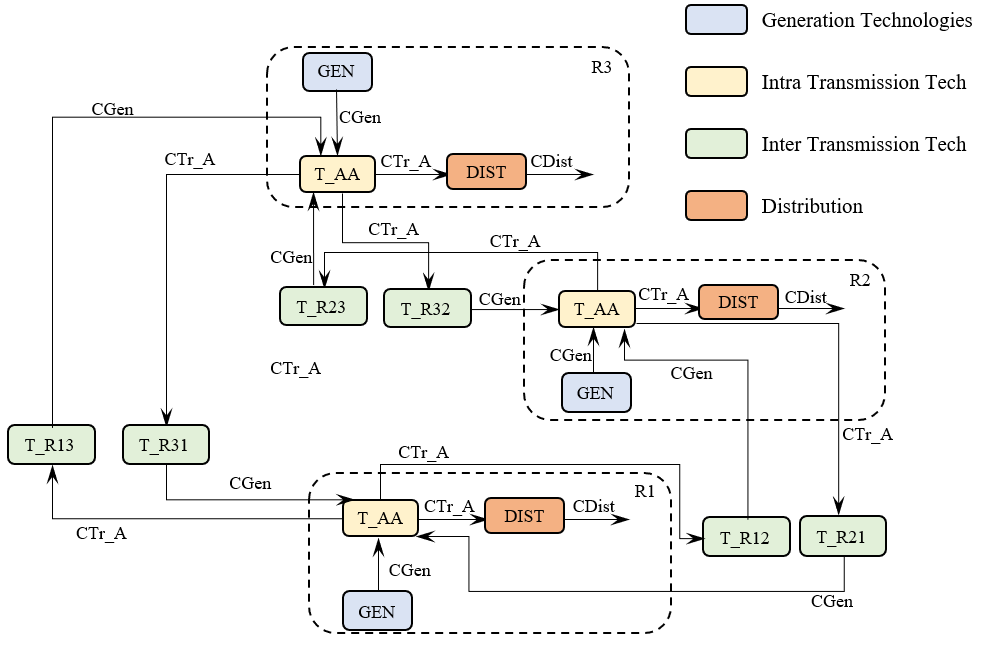

In [314]:
# For a system with three regions (R1-R2-R3) we consider the theoretical scenario where a single transmission system connects R1->R2 and R2->R3.
# As such the following connections must be defined:
# R1->R1 # R2->R2 # R3->R3
# R1->R2 # R2->R3

# On this theoretical framework we can use the current demand values of each region and the existing generation capacity and costs
# to calculate the size of each transmission system: This is done by running TEMOA with a single future period (2020-2022) 

# Additional data you need: 
# Total Transmission System Cost North Carolina
# Transmission system cost of interconnections ($/GW) R1>R2, R2>R3

# On temoa the transmission system costs R1<>R2 is divided by 2 to account for the fact that the transmission system is bidirectional
# As such we have two transmission lines R1->R2 and R2->R1. There is a constraint in the model to enforce that the two lines have the same capacity

#We represent the transmission in the same region by using an intermediate commodity. R1>R1, R2>R2, R3>R3

#------------------------------------------------------------------------------------------- Flow Diagram for the Transmission System ----------------------------------------------------------------------------------
#
Image(UserDataPath+"TransmissionConfiguration.png")

### Identify the Load Center in Each Region

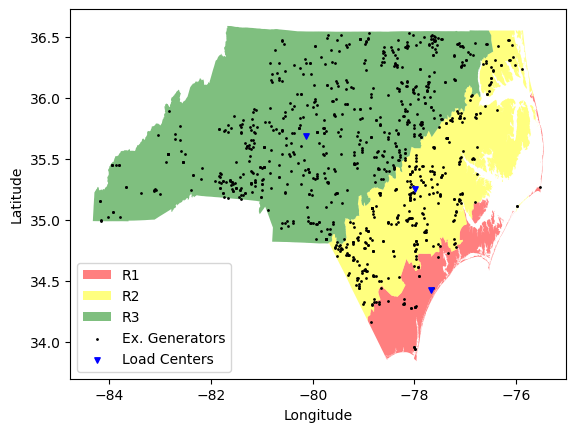

In [315]:
#Load center is defined based on the population of each county on the region (it is the same of the centroid of the population)
#shapefile_Pop and PointsPop is available at Demand chapter
PointsPopLongLat=np.array([[shapefile_Pop["LONGITUDE"][i],shapefile_Pop["LATITUDE"][i]] for i in range(len(shapefile_Pop))])
ListCensusPop=np.array(ListCensusPop)

CentroidLoadR1=np.sum(np.reshape(ListCensusPop[ListCensusOnR1]/np.sum(ListCensusPop[ListCensusOnR1]),(len(ListCensusOnR1),1))*PointsPopLongLat[ListCensusOnR1],axis=0)#Long Lat
CentroidLoadR2=np.sum(np.reshape(ListCensusPop[ListCensusOnR2]/np.sum(ListCensusPop[ListCensusOnR2]),(len(ListCensusOnR2),1))*PointsPopLongLat[ListCensusOnR2],axis=0)#Long Lat
CentroidLoadR3=np.sum(np.reshape(ListCensusPop[ListCensusOnR3]/np.sum(ListCensusPop[ListCensusOnR3]),(len(ListCensusOnR3),1))*PointsPopLongLat[ListCensusOnR3],axis=0)#Long Lat

#Computing distance between centroids
DistanceR1R2=haversine((CentroidLoadR1[1], CentroidLoadR1[0]), (CentroidLoadR2[1], CentroidLoadR2[0]), unit='mi') #Haversine works on lat long
DistanceR2R3=haversine((CentroidLoadR2[1], CentroidLoadR2[0]), (CentroidLoadR3[1], CentroidLoadR3[0]), unit='mi') #Haversine works on lat long


fig, ax = plt.subplots()

count=0
for geom in new_polyR1.geoms:    
    xs, ys = geom.exterior.xy    
    count=count+1
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none',label="R1")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

count=0
for geom in new_polyR2.geoms:    
    count=count+1
    xs, ys = geom.exterior.xy    
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none',label="R2")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none')


xs, ys = new_polyR3.exterior.xy    
ax.fill(xs, ys, alpha=0.5, fc='green', ec='none',label="R3")

LongLatCentroids=np.concatenate([np.array([CentroidLoadR1]),np.array([CentroidLoadR2]),np.array([CentroidLoadR3])],axis=0)

plt.scatter(df_AggregateGen["Longitude"],df_AggregateGen["Latitude"],color="black",s=1, label="Ex. Generators")
plt.scatter(LongLatCentroids[:,0],LongLatCentroids[:,1],color="blue",s=15,marker="v", label="Load Centers")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("OutputData/Figures/Load Centroids.png",dpi=600)



In [316]:
#CentroidLoadR1: close to Wilmington
#CentroidLoadR2: Goldsboro
#CentroidLoadR3: Lexington

### Costs (Investment Fixed and Variable)

In [317]:
#Read from excel
#The transmission cost between regions is defined based on ReEDS data and DUKE data (Miles & KV of transmission line)
#Tp compute it we use the diststance between centroids and the average transmission cost per mile per MW
TransmissionExcel = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='TransmissionCalculations')
AverageTranmsissionCost=TransmissionExcel.iloc[8,1] #[$/(MW*Mile)]
InvestmentCost_TransmissionR1R2=DistanceR1R2*AverageTranmsissionCost/1000 #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR2R3=DistanceR2R3*AverageTranmsissionCost/1000 #[M$/GW]
InvestmentCost_TransmissionR1R3=InvestmentCost_TransmissionR1R2+InvestmentCost_TransmissionR2R3 #Installing capacity in this line to connect R1 and R3 is the same as installing capacity in R1R2 and R2R3. We use this
#representation to facilitate the model formulation on temoa

#Regional Investment Cost
InvestmentCost_TransmissionR1R1=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR2R2=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR3R3=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]


In [318]:
#Change CostInvest_sql (Regional transmission)
CostInvest_sql.loc[(CostInvest_sql["tech"]=="TRANSMISSION_REGIONAL") & (CostInvest_sql["regions"]=="R1"),"cost_invest"]=InvestmentCost_TransmissionR1R1
CostInvest_sql.loc[(CostInvest_sql["tech"]=="TRANSMISSION_REGIONAL") & (CostInvest_sql["regions"]=="R2"),"cost_invest"]=InvestmentCost_TransmissionR2R2
CostInvest_sql.loc[(CostInvest_sql["tech"]=="TRANSMISSION_REGIONAL") & (CostInvest_sql["regions"]=="R3"),"cost_invest"]=InvestmentCost_TransmissionR3R3


#CostInvest_sql (Interregional transmission)
#Delete Transmission_Interregional on CostInvest_sql and rebuild properly on TEMOA notation
CostInvest_sql=CostInvest_sql[CostInvest_sql["tech"]!="TRANSMISSION_INTERREGIONAL"]

Data=[]
for vintage in FutureYears[:-1]:
    Data.append(["R1-R2", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR1R2, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R2-R1", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR1R2, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R2-R3", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR2R3, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R3-R2", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR2R3, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R1-R3", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR1R3, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R3-R1", "TRANSMISSION_INTERREGIONAL", vintage, InvestmentCost_TransmissionR1R3, "M$/GW", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostInvest_sql=pd.concat([CostInvest_sql,pd.DataFrame(Data,columns=CostInvest_sql.columns)],ignore_index=True)      

#CostVariable_sql (Interregional transmission)
#Delete Transmission_Interregional on CostVariable_sql and rebuild properly on TEMOA notation
CostVariable_sql=CostVariable_sql[CostVariable_sql["tech"]!="TRANSMISSION_INTERREGIONAL"]
VariableCost_InterTransmission=0 #[M$/PJ]=1/3.2*[$/Whr]
Data=[]

YearsToConsider=list([Vintages[0]])+list(FutureYears[:-1])
for i in range(len(YearsToConsider)):
    vintage=YearsToConsider[i]

    PeriodsToConsider=np.array(FutureYears[:-1])
    PeriodsToConsider=PeriodsToConsider[PeriodsToConsider>=vintage]

    for period in list(PeriodsToConsider):
        Data.append(["R1-R2",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R1",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R3",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R2",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R1-R3",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R1",period, "TRANSMISSION_INTERREGIONAL", vintage, VariableCost_InterTransmission, "M$/PJ", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)      

#CostFixed_sql (Interregional transmission)
#Delete Transmission_Interregional on CostVariable_sql and rebuild properly on TEMOA notation
CostFixed_sql=CostFixed_sql[CostFixed_sql["tech"]!="TRANSMISSION_INTERREGIONAL"]
FixedCost_InterTransmission=0
Data=[]
for i in range(len(YearsToConsider)):
    vintage=YearsToConsider[i]
    PeriodsToConsider=np.array(FutureYears[:-1])
    PeriodsToConsider=PeriodsToConsider[PeriodsToConsider>=vintage]
    for period in list(PeriodsToConsider):
        Data.append(["R1-R2",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R1",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R3",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R2",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R1-R3",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R1",period, "TRANSMISSION_INTERREGIONAL", vintage, FixedCost_InterTransmission, "M$/GWyr", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)


### Set Lifetech for Interregional Transmission

In [319]:
#For interregional transmission we need to properly define the regions using TEMOA "dash" notation
ExcelData=LifetimeTech_sql[(LifetimeTech_sql["tech"]=="TRANSMISSION_INTERREGIONAL") & (LifetimeTech_sql["Regions"]=="R3")]
life=ExcelData["life"].values[0]
life_notes=ExcelData["life_notes"].values[0]

LifetimeTech_sql=LifetimeTech_sql[LifetimeTech_sql["tech"]!="TRANSMISSION_INTERREGIONAL"]
Data=[]
Data.append(["R1-R2", "TRANSMISSION_INTERREGIONAL", life, life_notes])
Data.append(["R2-R1", "TRANSMISSION_INTERREGIONAL", life, life_notes])
Data.append(["R2-R3", "TRANSMISSION_INTERREGIONAL", life, life_notes])
Data.append(["R3-R2", "TRANSMISSION_INTERREGIONAL", life, life_notes])
Data.append(["R1-R3", "TRANSMISSION_INTERREGIONAL", life, life_notes])
Data.append(["R3-R1", "TRANSMISSION_INTERREGIONAL", life, life_notes])

LifetimeTech_sql=pd.concat([LifetimeTech_sql,pd.DataFrame(Data,columns=LifetimeTech_sql.columns)],ignore_index=True)

In [320]:
#Filter for year and lifetime
KeepRows=[]
for (region, period, tech, vintage) in zip(CostVariable_sql["regions"], CostVariable_sql["periods"], CostVariable_sql["tech"],CostVariable_sql["vintage"]):
    LifeOfTech=LifetimeTech_sql[(LifetimeTech_sql["tech"]==tech) * (LifetimeTech_sql["Regions"]==region)]["life"].iloc[0]

    if (vintage+LifeOfTech)<=period and period<vintage:
        KeepRows.append(False)

    else:
        KeepRows.append(True)

CostVariable_sql=CostVariable_sql[KeepRows]
CostFixed_sql=CostFixed_sql[KeepRows]


### Existing Capacity

In [321]:
#All existing transmission capacity is assumed to be in place in the earlies vintage year (all capacity on 2022)

#TEMOA has a constrain to enforce CapacityR1R2=CapacityR2R1,...
#Transmission_Interregional
ExistingCap_TransmissionR1R2=0.1 #[GW]
ExistingCap_TransmissionR2R3=0.1 #[GW]
ExistingCap_TransmissionR1R3=0.1 #[GW]

#Transmission_Regional
ExistingCap_TransmissionR1R1=0.1 #[GW]
ExistingCap_TransmissionR2R2=0.1 #[GW]
ExistingCap_TransmissionR3R3=0.1 #[GW]

#Need to define
Data=[]
Data.append(["R1-R2", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR1R2,	"GW",	"From Database Code"])
Data.append(["R2-R1", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR1R2,	"GW",	"From Database Code"])

Data.append(["R1-R3", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR2R3,	"GW",	"From Database Code"])
Data.append(["R3-R1", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR2R3,	"GW",	"From Database Code"])

Data.append(["R2-R3", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR1R3,	"GW",	"From Database Code"])
Data.append(["R3-R2", "TRANSMISSION_INTERREGIONAL", Vintages[0], ExistingCap_TransmissionR1R3,	"GW",	"From Database Code"])

Data.append(["R1", "TRANSMISSION_REGIONAL", Vintages[0], ExistingCap_TransmissionR1R1,	"GW",	"From Database Code"])
Data.append(["R2", "TRANSMISSION_REGIONAL", Vintages[0], ExistingCap_TransmissionR2R2,	"GW",	"From Database Code"])
Data.append(["R3", "TRANSMISSION_REGIONAL", Vintages[0], ExistingCap_TransmissionR3R3,	"GW",	"From Database Code"])

ExistingCapacity_sql=pd.concat([ExistingCapacity_sql,pd.DataFrame(Data,columns=ExistingCapacity_sql.columns)],ignore_index=True)


## tech_exchange

In [322]:
tech_exchange_sql=pd.DataFrame([["TRANSMISSION_INTERREGIONAL", "Transmission Interregions eg. R1>R2"]],columns=["tech","notes"])

# Code to Convert Excel Table to Sql data Part 2

## commodity_labels

In [323]:
#Read from excel
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='commodity_labels')
commodity_labels_sql=pd.DataFrame(ExcelDataP2.values,columns=["comm_labels","comm_labels_desc"])

## commodities

In [324]:
#Read from excel
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='commodities')
commodities_sql=pd.DataFrame(ExcelDataP2.values,columns=["comm_name","flag","comm_desc"])

## Efficiency

### Assign Efficiencies from Excel user data

In [325]:
#Construct the df for all valid combinations
#You can get all valid combinations for the future tech using CostInvest_sql
DummyString=np.array(['']*CostInvest_sql.shape[0])
DummyNumb=np.ones((CostInvest_sql.shape[0]))*-1
DataFuture=np.stack((CostInvest_sql["regions"].values,DummyString,CostInvest_sql["tech"].values,CostInvest_sql["vintage"].values,DummyString,DummyNumb,DummyString),axis=1)

#You can get all valid combinations for exising tech using ExistingCapacity_sql
DummyString=np.array(['']*ExistingCapacity_sql.shape[0])
DummyNumb=np.ones((ExistingCapacity_sql.shape[0]))*-1
DataPast=np.stack((ExistingCapacity_sql["regions"].values,DummyString,ExistingCapacity_sql["tech"].values,ExistingCapacity_sql["vintage"].values,DummyString,DummyNumb,DummyString),axis=1)


Efficiency_sql=pd.DataFrame(np.concatenate((DataFuture,DataPast),axis=0),columns=["regions","input_comm","tech","vintage","output_comm","efficiency","eff_notes"]) #Skelleton for the efficiency table
Efficiency_sql["units"]=""

#Transfer the data from the excel file to the dataframe
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='Efficiency')
ExcelDataP2=ExcelDataP2[(ExcelDataP2["Stage"]=="single") + (ExcelDataP2["Stage"]==UserScenario)]

#Transfer Input and output commodities
for tech, imput_comm, output_comm, units in zip(ExcelDataP2["tech"],ExcelDataP2["input_comm"],ExcelDataP2["output_comm"],ExcelDataP2["eff_units"]):
    Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"input_comm"]=imput_comm
    Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"output_comm"]=output_comm
    Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"units"]=units

for index, ExcelRowEffData in ExcelDataP2.iterrows():
    region=ExcelRowEffData["Region"]
    tech=ExcelRowEffData["tech"]
    eff_note=ExcelRowEffData["eff_notes"]

    if region=="single":
        Tech_vitages=Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"vintage"].values
        LastYearInEfficiencyTable=ExcelDataP2.columns[7]
        Tech_vitages[Tech_vitages<LastYearInEfficiencyTable]=LastYearInEfficiencyTable
        
        efficiency=[ExcelRowEffData[v] for v in Tech_vitages]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"eff_notes"]=eff_note

    if region!="single":
        Tech_vitages=Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region),"vintage"].values
        LastYearInEfficiencyTable=ExcelDataP2.columns[7]
        Tech_vitages[Tech_vitages<LastYearInEfficiencyTable]=LastYearInEfficiencyTable

        efficiency=[ExcelRowEffData[v] for v in Tech_vitages]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region) ,"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region) ,"eff_notes"]=eff_note

    if tech=="TRANSMISSION_INTERREGIONAL": #(Exception on Interregional Transmission) Same in both directions
        InvertRegion=region.split("-")[1]+"-"+region.split("-")[0]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==InvertRegion) ,"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==InvertRegion) ,"eff_notes"]=eff_note


#Verify that all the data is filled
if np.sum(Efficiency_sql["efficiency"]==-1)>0:
    print("ERROR: There are some efficiency values that are not filled")
    print(Efficiency_sql.loc[Efficiency_sql["efficiency"]==-1,:])
    sys.exit()

#Convert "MWh/MMBTUs" to "PJ/MMBTUs"
Efficiency_sql.loc[Efficiency_sql["units"]=="MWh/MMBTUs","efficiency"]=Efficiency_sql.loc[Efficiency_sql["units"]=="MWh/MMBTUs","efficiency"]*3.41214
Efficiency_sql.loc[Efficiency_sql["units"]=="MWh/MMBTUs","units"]="PJ/PJ"

Efficiency_sql["eff_notes"]=Efficiency_sql["eff_notes"]+"__"+Efficiency_sql["units"]
Efficiency_sql=Efficiency_sql.drop(columns=["units"])

### Assign Efficiencies for existing tech using EIA 923 BTUs to MWh

In [326]:
#Have to enter the value by hand on the efficiency table
EIA923_df = pd.read_excel(EIA_923_Path,sheet_name ='Page 1 Generation and Fuel Data',skiprows=5)
EIA923_State=EIA923_df["Plant State"]
EIA923_df=EIA923_df[EIA923_State==State]

EIA923_df=EIA923_df[(EIA923_df["Net Generation\n(Megawatthours)"]>0)*(EIA923_df["Elec Fuel Consumption\nMMBtu"]>0)] #If no fuel was consumed you cannot calculate the efficiency

#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
EIA923_df.loc[EIA923_df["Reported\nPrime Mover"]=="CT","Reported\nPrime Mover"]="CC"
EIA923_df.loc[EIA923_df["Reported\nPrime Mover"]=="CA","Reported\nPrime Mover"]="CC"


EIA923_Mover=EIA923_df["Reported\nPrime Mover"]
EIA923_FuelType=EIA923_df["Reported\nFuel Type Code"]
EIA923_FuelConsuption=EIA923_df["Elec Fuel Consumption\nMMBtu"]
EIA923_EnergyGen=EIA923_df["Net Generation\n(Megawatthours)"]

UniqueMoverFuel = EIA923_df[["Reported\nFuel Type Code","Reported\nPrime Mover"]].drop_duplicates()

UniqueMoverFuel["MMBtu"]=0
UniqueMoverFuel["MWh"]=0
for Mover, Fuel in zip(UniqueMoverFuel.iloc[:,1],UniqueMoverFuel.iloc[:,0]):
    Idx=(UniqueMoverFuel["Reported\nPrime Mover"]==Mover) * (UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel)

    UniqueMoverFuel.loc[Idx,"MMBtu"]=np.sum(EIA923_FuelConsuption[(EIA923_Mover==Mover) * (EIA923_FuelType==Fuel)])
    UniqueMoverFuel.loc[Idx,"MWh"]=np.sum(EIA923_EnergyGen[(EIA923_Mover==Mover) * (EIA923_FuelType==Fuel)])

UniqueMoverFuel["MWh/MMBtu"]=UniqueMoverFuel["MWh"]/UniqueMoverFuel["MMBtu"]
UniqueMoverFuel["MMBtu/MWh"]=UniqueMoverFuel["MMBtu"]/UniqueMoverFuel["MWh"]

In [327]:
UniqueMoverFuel.sort_values(['Reported\nFuel Type Code','Reported\nPrime Mover'], ascending=(True,True))

,Reported\nFuel Type Code,Reported\nPrime Mover,MMBtu,MWh,MWh/MMBtu,MMBtu/MWh
13834,AB,ST,72822,3.560000e+03,0.048886,20.455618
2203,BIT,ST,211992050,2.040464e+07,0.096252,10.389405
5301,BLQ,ST,5269578,9.924691e+05,0.188339,5.309564
933,DFO,CC,165286,1.624657e+04,0.098294,10.173594
935,DFO,GT,1283119,1.105445e+05,0.086153,11.607259
2249,DFO,IC,74515,6.304759e+03,0.084611,11.818850
2204,DFO,ST,610550,6.196798e+04,0.101495,9.852669
9863,LFG,FC,444152,5.477300e+04,0.123320,8.108959
6981,LFG,GT,1546018,9.531600e+04,0.061653,16.219921
7494,LFG,IC,3165782,2.988555e+05,0.094402,10.593018


In [328]:
#mean given all biomass fuels
BioFuel=["AB","BLQ","OBG","WDS"]
BTU=0
MWh=0
for Fuel in BioFuel:
    Idx=UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel
    BTU=BTU+np.sum(UniqueMoverFuel.loc[Idx,"MMBtu"])
    MWh=MWh+np.sum(UniqueMoverFuel.loc[Idx,"MWh"])

print("Average Biomass Efficiency MMBTU/MWh: %.4f" % (BTU/MWh))

#Mean of Tech Specific:
Coal =["BIT"]
NG   =["NG"]
Petroleum=["DFO","KER", "RFO"]

RefFuel=NG
BTU=0
MWh=0
for Fuel in RefFuel:
    Idx=UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel
    BTU=BTU+np.sum(UniqueMoverFuel.loc[Idx,"MMBtu"])
    MWh=MWh+np.sum(UniqueMoverFuel.loc[Idx,"MWh"])

print("\n\nAverage Tech Specific Efficiency MMBTU/MWh: %.4f\nTech Specific Total MMBTUs: %.2f" % (BTU/MWh,BTU))

Average Biomass Efficiency MMBTU/MWh: 7.2141


Average Tech Specific Efficiency MMBTU/MWh: 8.6686
Tech Specific Total MMBTUs: 375669277.00


## EmissionActivity

In [329]:

#From https://www.pfpi.net/wp-content/uploads/2018/04/PFPIetal.CapandTradeComments4.9.2018.pdf lb/MMBTU of Co2

BioFuel_LbPerMMBTU={"OBS":223,
                    "BLQ":222,
                    "WDS":207,
                    "LFG":127,
                    "AB":0
                    }

TotalMMBtu=0
AverageLbPerMMBTU=0
for FT in list(BioFuel_LbPerMMBTU.keys()):
    TotalMMBtu+=UniqueMoverFuel.loc[UniqueMoverFuel["Reported\nFuel Type Code"]==FT,"MMBtu"].sum()
    AverageLbPerMMBTU+=UniqueMoverFuel.loc[UniqueMoverFuel["Reported\nFuel Type Code"]==FT,"MMBtu"].sum()*BioFuel_LbPerMMBTU[FT]
AverageLbPerMMBTU=AverageLbPerMMBTU/TotalMMBtu

print("Average Biomass Lb co2 /MMBTU: %.2f" % (AverageLbPerMMBTU))

Average Biomass Lb co2 /MMBTU: 188.17


In [330]:
#Get the technologies we need to model efficiency from EmissionActivity on the excel file
#An get the sql structure from Efficiency_sql
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='EmissionActivity')

EmissionActivity_sql=pd.DataFrame(columns=["regions","emis_comm","input_comm","tech","vintage","output_comm","emis_act","emis_act_units","emis_act_notes"])



for i in range(len(ExcelDataP2["tech"])):
    tech=ExcelDataP2["tech"][i]
    MMBtus2Lbs=ExcelDataP2["emission_act"][i]
    units=ExcelDataP2["units"][i]
    emission_comm=ExcelDataP2["emission_comm"][i]
    IdxIn=Efficiency_sql["tech"]==tech
    Filtered_df_Emissions=Efficiency_sql[IdxIn]

    #Get data we need from emissions considering the tech
    regions=Filtered_df_Emissions["regions"]
    input_comm=Filtered_df_Emissions["input_comm"]
    tech=Filtered_df_Emissions["tech"]
    vintage=Filtered_df_Emissions["vintage"]
    output_comm=Filtered_df_Emissions["output_comm"]
    efficiency=Filtered_df_Emissions["efficiency"]/3.41214 #Convert from PJ/PJ to[MWh/MBTUs]

    if units=="lbs/MMBtu":

        emissions=MMBtus2Lbs*1/efficiency #[lbs/MWh]
        emissions=emissions*0.0005/(3.6*10**-6)/1000 #[kt/PJ]
        new_units="kt/PJ"
        EmissionActivity_tmp_sql = pd.DataFrame({"regions":regions,
                                    "emis_comm":emission_comm,
                                    "input_comm":input_comm,
                                    "tech":tech,
                                    "vintage":vintage,
                                    "output_comm":output_comm,
                                    "emis_act":emissions,
                                    "emis_act_units":new_units,
                                    "emis_act_notes":"Check Code"})
        
        EmissionActivity_sql = pd.concat([EmissionActivity_sql, EmissionActivity_tmp_sql], ignore_index=True, sort=False)

    if units=="kt/kt":
        kt_kt=MMBtus2Lbs
        emissions=kt_kt
        new_units="kt/kt"
        EmissionActivity_tmp_sql = pd.DataFrame({"regions":regions,
                                    "emis_comm":emission_comm,
                                    "input_comm":input_comm,
                                    "tech":tech,
                                    "vintage":vintage,
                                    "output_comm":output_comm,
                                    "emis_act":emissions,
                                    "emis_act_units":new_units,
                                    "emis_act_notes":"Check Code"})
        
        EmissionActivity_sql = pd.concat([EmissionActivity_sql, EmissionActivity_tmp_sql], ignore_index=True, sort=False)

## DemandSpecificDistribution

In [331]:
# Data from EIA-930 form (https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48)
# Get hourly demand data from EIA froms to know how the demand changes for each season an hour of the day
EIA_930_Paths = glob.glob(EIA_930_BalancePath + "\*.csv")

EIA_Data=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])
for FilePath in EIA_930_Paths:
    df = pd.read_csv(FilePath,usecols = ["Balancing Authority",'Data Date',"Hour Number",'Demand (MW)'],low_memory=False)

    BAsIn=df["Balancing Authority"]==MajorBAs[0] # Initialize the boolean array to select the BAs
    for BA in MajorBAs:
        BAsIn=(df["Balancing Authority"]==BA) + BAsIn
    df=df[BAsIn]

    FileData=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])
    FileData["Demand (MW)"]=df["Demand (MW)"].str.replace(',', '').astype(float)
    FileData["Year"]=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.year
    FileData["Hour"]=df["Hour Number"]

    Month=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.month
    SeasonDf=[]
    for month in Month:
        for j in range(len(Seasons)):
            if month in SeasonsMonthRange[j]:
                SeasonDf.append(Seasons[j])
                break
    FileData["Season"]=SeasonDf

    EIA_Data = pd.concat([EIA_Data,FileData], ignore_index = True)

    EIA_Data=EIA_Data[EIA_Data["Hour"]!=25] #Remove the 25th hour. On the EIA some days have 25 hours. I don't know why

In [332]:
Demand_Season_Hour_agg=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])

for Season in Seasons:
    for Hour in EIA_Data["Hour"].unique():
        for Year in EIA_Data["Year"].unique():
            IdxIn=(EIA_Data["Season"]==Season)*(EIA_Data["Hour"]==Hour)*(EIA_Data["Year"]==Year)
            df=EIA_Data[IdxIn]
            Demand=df["Demand (MW)"].sum()
            Demand_Season_Hour_agg=pd.concat([Demand_Season_Hour_agg,pd.DataFrame([{"Year":Year,"Season":Season,"Hour":Hour,"Demand (MW)":Demand}])], ignore_index=True)

#Make demand as a percentage of the total demand on the year
for Year in Demand_Season_Hour_agg["Year"].unique():
    IdxIn=Demand_Season_Hour_agg["Year"]==Year
    Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"]=Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"]/Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"].sum()

Demand_Season_Hour_agg=Demand_Season_Hour_agg.rename(columns={"Demand (MW)": "RatioOfYearDemand"})

#Get the average Trend
GeneralDemandDistribuion=pd.DataFrame(columns=["Season","Hour", "RatioOfDemand"])

for Season in Seasons:
    for Hour in Demand_Season_Hour_agg["Hour"].unique():
        IdxIn=(Demand_Season_Hour_agg["Season"]==Season)*(Demand_Season_Hour_agg["Hour"]==Hour)
        df=Demand_Season_Hour_agg[IdxIn]
        RatioOfDemand=df["RatioOfYearDemand"].mean()#Mean of all years
        GeneralDemandDistribuion=pd.concat([GeneralDemandDistribuion,pd.DataFrame([{"Season":Season,"Hour":Hour,"RatioOfDemand":RatioOfDemand}])], ignore_index=True)

### Plot Demand Specific Distribution

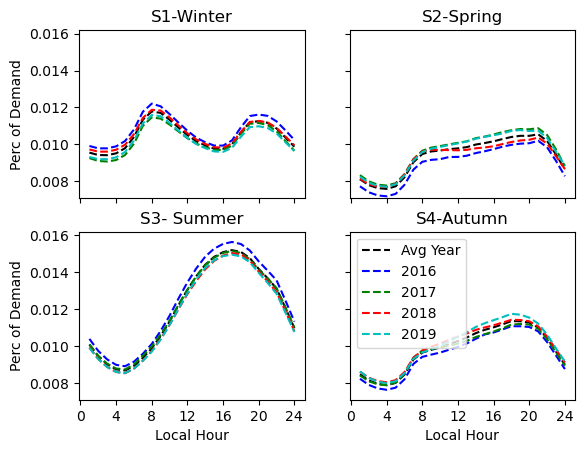

In [333]:
fig, axs = plt.subplots(2, 2)
G_S1Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S1"]
G_S2Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S2"]
G_S3Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S3"]
G_S4Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S4"]
x=G_S2Data["Hour"].unique()

MinY=-0.0005+min(G_S1Data["RatioOfDemand"].min(),G_S2Data["RatioOfDemand"].min(),G_S3Data["RatioOfDemand"].min(),G_S4Data["RatioOfDemand"].min())
MaxY=0.001+max(G_S1Data["RatioOfDemand"].max(),G_S2Data["RatioOfDemand"].max(),G_S3Data["RatioOfDemand"].max(),G_S4Data["RatioOfDemand"].max())

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3- Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))

axs[0, 0].plot(x, G_S1Data["RatioOfDemand"],"k--")
axs[0, 1].plot(x, G_S2Data["RatioOfDemand"],"k--")
axs[1, 0].plot(x, G_S3Data["RatioOfDemand"],"k--")
axs[1, 1].plot(x, G_S4Data["RatioOfDemand"],"k--",label="Avg Year")

Colors=list(mcolors.BASE_COLORS.keys())
for i in range(len(Demand_Season_Hour_agg["Year"].unique())):
    year=Demand_Season_Hour_agg["Year"].unique()[i]
    G_S1Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S1")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S2Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S2")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S3Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S3")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S4Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S4")*(Demand_Season_Hour_agg["Year"]==year)]

    axs[0, 0].plot(x, G_S1Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[0, 1].plot(x, G_S2Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[1, 0].plot(x, G_S3Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[1, 1].plot(x, G_S4Data["RatioOfYearDemand"],Colors[i]+"--",label=year)

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='Perc of Demand')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()


### Plot Load Distribution

In [334]:
season="S1"
year=2019

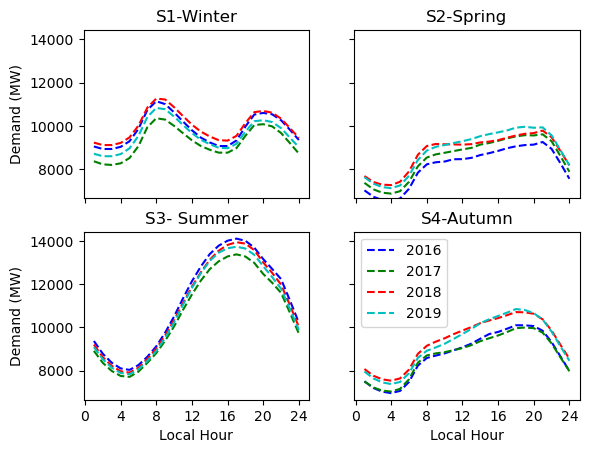

In [335]:
fig, axs = plt.subplots(2, 2)
G_S1Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S1"]
G_S2Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S2"]
G_S3Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S3"]
G_S4Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S4"]
x=np.arange(0, 24+1, 1)

MinY=-0.0005+min(G_S1Data["RatioOfDemand"].min(),G_S2Data["RatioOfDemand"].min(),G_S3Data["RatioOfDemand"].min(),G_S4Data["RatioOfDemand"].min())
MaxY=0.001+max(G_S1Data["RatioOfDemand"].max(),G_S2Data["RatioOfDemand"].max(),G_S3Data["RatioOfDemand"].max(),G_S4Data["RatioOfDemand"].max())

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3- Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))



Colors=list(mcolors.BASE_COLORS.keys())

for i in range(len(EIA_Data["Year"].unique())):
    year=EIA_Data["Year"].unique()[i]
    for season in Seasons:
        MaxLoad=[]
        MeanLoad=[]
        MinLoad=[]
        for hour in list(np.arange(0,24+1,1)):
            MaxLoad.append(EIA_Data.loc[(EIA_Data["Hour"]==hour)*(EIA_Data["Season"]==season)*(EIA_Data["Year"]==year),"Demand (MW)"].max())
            MinLoad.append(EIA_Data.loc[(EIA_Data["Hour"]==hour)*(EIA_Data["Season"]==season)*(EIA_Data["Year"]==year),"Demand (MW)"].min())
            MeanLoad.append(EIA_Data.loc[(EIA_Data["Hour"]==hour)*(EIA_Data["Season"]==season)*(EIA_Data["Year"]==year),"Demand (MW)"].mean())
            y=MeanLoad
        if season=="S1":
            axs[0, 0].plot(x, y,Colors[i]+"--",label = str(year))
        if season=="S2":
            axs[0, 1].plot(x, y,Colors[i]+"--",label = str(year))
        if season=="S3":
            axs[1, 0].plot(x, y,Colors[i]+"--",label = str(year))
        if season=="S4":
            axs[1, 1].plot(x, y,Colors[i]+"--",label = str(year))

MinY, MaxY = axs[1, 0].get_ylim()
MinY=MinY*0.9
MaxY=MaxY*1
axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='Demand (MW)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()

### Write df on sql format

In [336]:
dds_notes="From EIA-930 Forms"

Data=[]
for region in RegionsDefinition:
    for hour in range(len(TimeOfDay)):
        for season in Seasons:
            demand_name="ELCDMD"
            dds=GeneralDemandDistribuion[(GeneralDemandDistribuion["Season"]==season)*(GeneralDemandDistribuion["Hour"]==(hour+1))]["RatioOfDemand"].values[0]
            Data.append([region, season, TimeOfDay[hour],demand_name,dds,dds_notes])
        
DemandSpecificDistribution_sql=pd.DataFrame(Data, columns=["regions","season_name","time_of_day_name", "demand_name","dds","dds_notes"])


## CapacityFactorProcess

### Estimate CF based on EIA 930

In [337]:
# Estimate CF based on EIA 930
TechEIA_SummaryFile=["Petroleum","Pumped storage","Other biomass","Solar"] #technology name on EIA summary file
Tech2EIA_930= {"Coal_EIA930":           "Net Generation (MW) from Coal",
                "NG_EIA930":             "Net Generation (MW) from Natural Gas",
                "Nuclear_EIA930":        "Net Generation (MW) from Nuclear",
                "Petroleum_EIA930":      "Net Generation (MW) from All Petroleum Products",
                "WATER_EIA930":          "Net Generation (MW) from Hydropower and Pumped Storage",
                "WIND_EIA930":           "Net Generation (MW) from Wind",
                "SOL_EIA930":            "Net Generation (MW) from Solar (Adjusted)"}

def EIA930_CFs(Tech, AvgY_CF):
    EIA930_Column=Tech2EIA_930[Tech]
    EIA_930_Paths = glob.glob(EIA_930_CFPath + "\*.csv")

    EIA_Data=pd.DataFrame(columns=["Year","Season","Hour", "Generation (MW)"])
    for FilePath in EIA_930_Paths:
        df = pd.read_csv(FilePath,usecols = ["Balancing Authority",'Data Date',"Hour Number",EIA930_Column],low_memory=False)

        BAsIn=df["Balancing Authority"]==MajorBAs[0] # Initialize the boolean array to select the BAs
        for BA in MajorBAs:
            BAsIn=(df["Balancing Authority"]==BA) + BAsIn
        df=df[BAsIn]

        FileData=pd.DataFrame(columns=["Year","Season","Hour", "Generation (MW)"])
        FileData["Generation (MW)"]=df[EIA930_Column].str.replace(',', '').astype(float)
        FileData["Year"]=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.year
        FileData["Hour"]=df["Hour Number"]

        Month=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.month
        SeasonDf=[]
        for month in Month:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break
        FileData["Season"]=SeasonDf

        EIA_Data = pd.concat([EIA_Data,FileData], ignore_index = True)


    EIA_Data=EIA_Data[EIA_Data["Hour"]!=25] #Remove the 25th hour. On the EIA some days have 25 hours. I don't know why

    PercentageNegative=-np.sum(EIA_Data.loc[EIA_Data["Generation (MW)"]<0,"Generation (MW)"])/np.sum(EIA_Data.loc[EIA_Data["Generation (MW)"]>0,"Generation (MW)"])*100
    if PercentageNegative>1:
        print("Warning: Negative generation is more than 1% of total generation, It is not advisable to use this data")
        print("EIA 930 Tech With Problem: %s  \n Percentage Negative %.1f %" % (Tech,PercentageNegative))
        sys.exit()

    EIA_Data.loc[EIA_Data["Generation (MW)"]<0,"Generation (MW)"]=0 #Remove negative values, assume they are only a very small fraction of the total generation

    AverageGen=pd.DataFrame(columns=["Season","Hour", "AvgGen","CF"])
    for Season in Seasons:
        for Hour in EIA_Data["Hour"].unique():
            IdxIn=(EIA_Data["Season"]==Season)*(EIA_Data["Hour"]==Hour)
            df=EIA_Data[IdxIn]
            AvgGen=df["Generation (MW)"].mean()#Mean of all years
            AverageGen=pd.concat([AverageGen,pd.DataFrame([{"Season":Season,"Hour":Hour,"AvgGen":AvgGen, "CF":-1}])], ignore_index=True)

    #Expected sum gen in a year
    TGen=0
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageGen["Season"]==Season)
        df=AverageGen[IdxIn]
        TGen+=df["AvgGen"].sum()*NumDaysSeason #Proxy for Total energy generation in a year

    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24

        IdxIn=(AverageGen["Season"]==Season)
        df=AverageGen[IdxIn]
        DistributionBySeason=df["AvgGen"].sum()*NumDaysSeason/TGen


        CF=AvgY_CF*365.25*24*(df["AvgGen"]/df["AvgGen"].sum())*DistributionBySeason/(NumHoursSeason[Season]/24)
        CF[CF<0.005]=0 # For some reason we have some small generation at night
        AverageGen.loc[IdxIn,"CF"]=CF #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (CSP)

    return AverageGen
    

In [338]:
def CFPlotEIA930(AverageGen):

    R_S1Data=AverageGen[AverageGen["Season"]=="S1"]
    R_S2Data=AverageGen[AverageGen["Season"]=="S2"]
    R_S3Data=AverageGen[AverageGen["Season"]=="S3"]
    R_S4Data=AverageGen[AverageGen["Season"]=="S4"]


    x=R_S4Data["Hour"].unique()

    MinY=max(AverageGen["CF"].min()-0.05,0)
    MaxY=min(AverageGen["CF"].max()+0.05,1)

    #set ticks x axis
    plt.xticks(np.arange(0, 24+1, 4))


    Colors=list(mcolors.BASE_COLORS.keys())
    plt.plot(x, R_S1Data["CF"].values,Colors[0]+"--",label='S1-Winter')
    plt.plot(x, R_S2Data["CF"].values,Colors[1]+"--",label='S2-Spring')
    plt.plot(x, R_S3Data["CF"].values,Colors[2]+"--",label='S3-Summer')
    plt.plot(x, R_S4Data["CF"].values,Colors[3]+"--",label='S4-Autumn')
    plt.xlabel("Local Hour")
    plt.ylabel('CF')

    plt.legend()
    return plt.show()

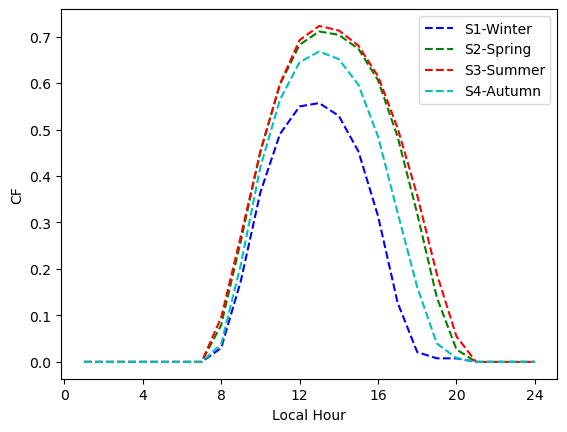

In [339]:
#Example
Tech="SOL_EIA930"
AvgY_CF=0.21 #CF from 2021 NC summary statistics
AverageGen=EIA930_CFs(Tech, AvgY_CF)
CFPlotEIA930(AverageGen)

### Solar

In [340]:
# For solar energy we donwload irradiation data from SAM model of NREL at the 3 centroid locations determined by the load (CentroidLoadR1,CentroidLoadR2,CentroidLoadR3)
# And define the distribution CF of the solar energy using irradiation ratios

#Read All Data On Region R1,R2,R3 for solar DNI-Direct Normal Irradiation
def GetAverageDNI_GHI(Region):
    SAMPaths = glob.glob(SAM_NREL_Path+"Sun/"+Region + "\*.csv")
    FileData=pd.DataFrame(columns=["Year","Season","Hour", "DNI","GHI"])

    for FilePath in SAMPaths:
        df = pd.read_csv(FilePath,skiprows=2,low_memory=False,usecols = ["Year","Month",'Hour', "DNI","GHI","Temperature"])
        
        SeasonDf=[]
        for month in df["Month"]:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break

        FileData = pd.concat([FileData,pd.DataFrame({"Year":df["Year"],"Hour":df["Hour"],"DNI":df["DNI"],"Season":SeasonDf,"GHI":df["GHI"]})], ignore_index = True)
        #Hour 0 is 24:00 of the previous day, we change it to 24h of the current day (which is not fully correct but it is a good approximation given the data size and the averages we are going to take)
        #Improve it later
    FileData.loc[FileData["Hour"]==0,"Hour"]=24 

    AverageDNI_GHI=pd.DataFrame(columns=["Season","Hour", "DNI","GHI","RatioOfDNI","RatioOfGHI"])
    for Season in Seasons:
        for Hour in FileData["Hour"].unique():
            IdxIn=(FileData["Season"]==Season)*(FileData["Hour"]==Hour)
            df=FileData[IdxIn]
            DNIValue=df["DNI"].mean()#Mean of all years
            GHIValue=df["GHI"].mean()#Mean of all years
            AverageDNI_GHI=pd.concat([AverageDNI_GHI,pd.DataFrame([{"Season":Season,"Hour":Hour,"DNI":DNIValue, "GHI":GHIValue, "RatioOfDNI":-1,"RatioOfGHI":-1}])], ignore_index=True)

    #Expected sum total Irradiation in a year
    TIrr_DNI=0
    TIrr_GHI=0
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageDNI_GHI["Season"]==Season)
        df=AverageDNI_GHI[IdxIn]
        TIrr_DNI+=df["DNI"].sum()*NumDaysSeason #Proxy for Total energy generation in a year
        TIrr_GHI+=df["GHI"].sum()*NumDaysSeason

    DistributionBySeason_DHI=[]
    DistributionBySeason_GHI=[]
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageDNI_GHI["Season"]==Season)
        df=AverageDNI_GHI[IdxIn]

        RatioOfDNI=df["DNI"]/df["DNI"].sum()
        AverageDNI_GHI.loc[IdxIn,"RatioOfDNI"]=RatioOfDNI #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (CSP)

        RatioOfGHI=df["GHI"]/df["GHI"].sum()
        AverageDNI_GHI.loc[IdxIn,"RatioOfGHI"]=RatioOfGHI #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (PV)

        DistributionBySeason_DHI.append(df["DNI"].sum()*NumDaysSeason/TIrr_DNI)
        DistributionBySeason_GHI.append(df["GHI"].sum()*NumDaysSeason/TIrr_GHI)

    DistributionBySeason=pd.DataFrame({"Season":Seasons,"RatioOfDNI":DistributionBySeason_DHI,"RatioOfGHI":DistributionBySeason_GHI})

    return AverageDNI_GHI,DistributionBySeason

AverageDNI_GHI_R1, DistributionBySeason_R1 = GetAverageDNI_GHI("R1")
AverageDNI_GHI_R2, DistributionBySeason_R2 = GetAverageDNI_GHI("R2")
AverageDNI_GHI_R3, DistributionBySeason_R3 = GetAverageDNI_GHI("R3")


#### Plot Distribution of Solar Radiation

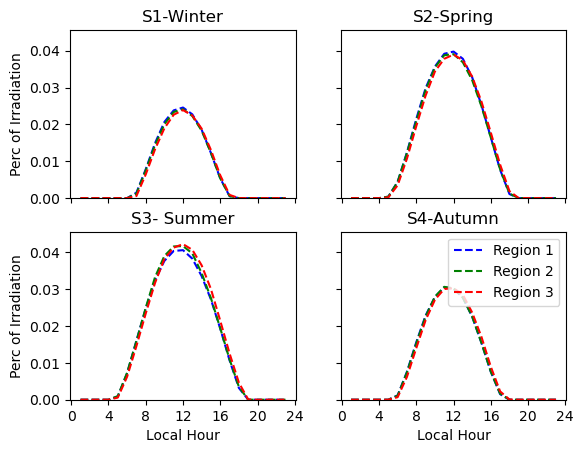

In [341]:
fig, axs = plt.subplots(2, 2)
R_S1Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S1"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S1"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S1"]]
R_S2Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S2"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S2"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S2"]]
R_S3Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S3"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S3"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S3"]]
R_S4Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S4"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S4"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S4"]]

R_S1=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S1"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S1"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S1"]]
R_S2=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S2"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S2"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S2"]]
R_S3=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S3"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S3"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S3"]]
R_S4=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S4"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S4"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S4"]]

R1_S3Data=AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S3"]
R1_S3=DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S3"]
x=R1_S3Data["Hour"].unique()

MinY=0
MaxY=0.005+(R1_S3Data["RatioOfGHI"]*R1_S3["RatioOfGHI"].values[0]).max()

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3- Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))



Colors=list(mcolors.BASE_COLORS.keys())
for i in range(3):
    axs[0, 0].plot(x[1:], R_S1Data[i]["RatioOfGHI"][1:]*R_S1[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[0, 1].plot(x[1:], R_S2Data[i]["RatioOfGHI"][1:]*R_S2[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 0].plot(x[1:], R_S3Data[i]["RatioOfGHI"][1:]*R_S3[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 1].plot(x[1:], R_S4Data[i]["RatioOfGHI"][1:]*R_S4[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='Perc of Irradiation')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()

In [342]:
AverageGHI_Year_R1=AverageDNI_GHI_R1["GHI"].sum()/len(Seasons)/1000 #Kwh/m2/day
AverageGHI_Year_R2=AverageDNI_GHI_R2["GHI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageGHI_Year_R3=AverageDNI_GHI_R3["GHI"].sum()/len(Seasons)/1000  #Kwh/m2/day

AverageDNI_Year_R1=AverageDNI_GHI_R1["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageDNI_Year_R2=AverageDNI_GHI_R2["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageDNI_Year_R3=AverageDNI_GHI_R3["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day

#NC was a GHI arond 4.5-4.75 which is Class 6 on the Utility-Scale/Commercial/Residential PV notation on NREL ATB-22
#NC was a DNI around 5 which is Class 12 on the Concentrating Solar Power notation on NREL ATB-22 - The CFs of this technology are not mapped on the ATB-22. Since it is a poor resource we did not map it on NC


#### Existing Solar Residential and Comercial

### Wind

In [343]:
#Get turbine data
#some supply curves: https://www.nrel.gov/gis/wind-supply-curves.html
def ReadTrubineData(NameDistribution):
    FilePath=SAM_NREL_Path+"Wind/Turbines.xlsx"
    df = pd.read_excel(FilePath,sheet_name=NameDistribution)
    HubHeight=df.iloc[0,0]
    Efficiency=df.iloc[0,1]
    WS_PowerCurve=df.iloc[:,4]
    CF_PowerCurve=df.iloc[:,5]
    WS_2_CF = lambda WS : np.interp(WS, WS_PowerCurve, CF_PowerCurve)*Efficiency

    return HubHeight,Efficiency,WS_2_CF

In [344]:
def CF_Wind(Region, NameDistribution):
#Read Excel with wind data

    if NameDistribution=="OFFSHORE":
        SAMPaths = glob.glob(SAM_NREL_Path+"Wind/Offshore" + "\*.csv")
    if NameDistribution=="LAND":
        SAMPaths = glob.glob(SAM_NREL_Path+"Wind/"+Region + "\*.csv")
        
    FileData=pd.DataFrame(columns=["Season","Hour", "CF"])
    HubHeight,Efficiency,WS_2_CF=ReadTrubineData(NameDistribution)

    for FilePath in SAMPaths:
        df = pd.read_csv(FilePath,skiprows=1,low_memory=False,usecols = ["Year","Month",'Hour', "wind speed at 100m (m/s)","wind speed at 120m (m/s)"])
        SeasonDf=[]
        for month in df["Month"]:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break
                
        WS100=df["wind speed at 100m (m/s)"]
        WS120=df["wind speed at 120m (m/s)"]
        WindSpeedAdjusted = WS100 + (HubHeight-100)*(WS120-WS100)/(120-100) #Linear interpolation between 100m and 120m at the hub height
        WindSpeed110 = WS100 + (110-100)*(WS120-WS100)/(120-100) #Linear interpolation between 100m and 120m at the hub height
        CF=WS_2_CF(WindSpeedAdjusted)
        
        FileData = pd.concat([FileData,pd.DataFrame({"Hour":df["Hour"],"Season":SeasonDf,"CF":CF,"WS110":WindSpeed110})], ignore_index = True)

    #Hour 0 is 24:00 of the previous day, we change it to 24h of the current day (which is not fully correct but it is a good approximation given the data size and the averages we are going to take)
    #Improve it later
    FileData.loc[FileData["Hour"]==0,"Hour"]=24 
    WS_Statistics={"Mean":FileData["WS110"].mean(),
                   "Q75":FileData["WS110"].quantile(0.75),
                   "Q25":FileData["WS110"].quantile(0.25)}

    AverageCF=pd.DataFrame(columns=["Season","Hour", "CF"])
    for Season in Seasons:
        for Hour in FileData["Hour"].unique():
            IdxIn=(FileData["Season"]==Season)*(FileData["Hour"]==Hour)
            df=FileData[IdxIn]
            CF_AVG=df["CF"].mean()#Mean of all years

            AverageCF=pd.concat([AverageCF,pd.DataFrame([{"Hour":Hour,"Season":Season,"CF":CF_AVG}])], ignore_index=True)
            
    return AverageCF, WS_Statistics

AverageCF_R1,WS_Statistics_R1=CF_Wind("R1", "LAND")
AverageCF_R2,WS_Statistics_R2=CF_Wind("R2", "LAND")
AverageCF_R3,WS_Statistics_R3=CF_Wind("R3", "LAND")
AverageCF_Off,WS_Statistics_Off=CF_Wind("R3", "OFFSHORE")

#### Plot Distribution of Wind CF

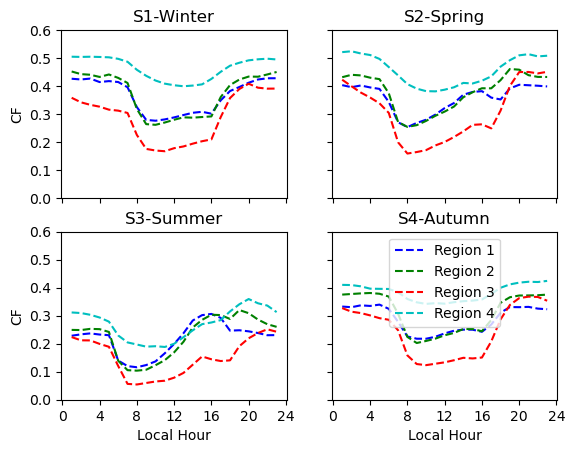

In [345]:
fig, axs = plt.subplots(2, 2)
R_S1Data=[AverageCF_R1[AverageCF_R1["Season"]=="S1"],AverageCF_R2[AverageCF_R2["Season"]=="S1"],AverageCF_R3[AverageCF_R3["Season"]=="S1"],AverageCF_Off[AverageCF_Off["Season"]=="S1"]]
R_S2Data=[AverageCF_R1[AverageCF_R1["Season"]=="S2"],AverageCF_R2[AverageCF_R2["Season"]=="S2"],AverageCF_R3[AverageCF_R3["Season"]=="S2"],AverageCF_Off[AverageCF_Off["Season"]=="S2"]]
R_S3Data=[AverageCF_R1[AverageCF_R1["Season"]=="S3"],AverageCF_R2[AverageCF_R2["Season"]=="S3"],AverageCF_R3[AverageCF_R3["Season"]=="S3"],AverageCF_Off[AverageCF_Off["Season"]=="S3"]]
R_S4Data=[AverageCF_R1[AverageCF_R1["Season"]=="S4"],AverageCF_R2[AverageCF_R2["Season"]=="S4"],AverageCF_R3[AverageCF_R3["Season"]=="S4"],AverageCF_Off[AverageCF_Off["Season"]=="S4"]]


x=AverageCF_Off["Hour"].unique()

MinY=0
MaxY=0.6

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3-Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))



Colors=list(mcolors.BASE_COLORS.keys())
for i in range(4):
    axs[0, 0].plot(x[1:], R_S1Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[0, 1].plot(x[1:], R_S2Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 0].plot(x[1:], R_S3Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 1].plot(x[1:], R_S4Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='CF')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()

In [346]:
print("Average CF for R1: "+str(AverageCF_R1["CF"].mean()))
print("Average CF for R2: "+str(AverageCF_R2["CF"].mean()))
print("Average CF for R3: "+str(AverageCF_R3["CF"].mean()))
print("Average CF for Offshore: "+str(AverageCF_Off["CF"].mean()))

print("\n\nAverage WS for R1: %.2f \nQ75 WS for R1: %.2f \nQ25 WS for R1: %.2f"%(WS_Statistics_R1["Mean"],WS_Statistics_R1["Q75"],WS_Statistics_R1["Q25"]))
print("\n\nAverage WS for R2: %.2f \nQ75 WS for R2: %.2f \nQ25 WS for R2: %.2f"%(WS_Statistics_R2["Mean"],WS_Statistics_R2["Q75"],WS_Statistics_R2["Q25"]))
print("\n\nAverage WS for R3: %.2f \nQ75 WS for R3: %.2f \nQ25 WS for R3: %.2f"%(WS_Statistics_R3["Mean"],WS_Statistics_R3["Q75"],WS_Statistics_R3["Q25"]))
print("\n\nAverage WS for Offshore: %.2f \nQ75 WS for Offshore: %.2f \nQ25 WS for Offshore: %.2f"%(WS_Statistics_Off["Mean"],WS_Statistics_Off["Q75"],WS_Statistics_Off["Q25"]))


Average CF for R1: 0.30853005879759604
Average CF for R2: 0.3241554154135524
Average CF for R3: 0.25153295158986805
Average CF for Offshore: 0.3950057484186728


Average WS for R1: 7.06 
Q75 WS for R1: 9.05 
Q25 WS for R1: 4.88


Average WS for R2: 7.19 
Q75 WS for R2: 9.38 
Q25 WS for R2: 4.80


Average WS for R3: 6.26 
Q75 WS for R3: 8.61 
Q25 WS for R3: 3.67


Average WS for Offshore: 7.90 
Q75 WS for Offshore: 10.29 
Q25 WS for Offshore: 5.17


### Hydro

In [347]:
#The precipitation modulates the probability distribution of the CF. Which yearly values come from ORNL
def CF_Hydro(Region):
    HydroData_df = pd.read_excel(HydroDataPath,skiprows=1,sheet_name="Operational")
    HydroData_df=HydroData_df[HydroData_df["State"]==State] #Hydro Data for NC
    HydroData_df=HydroData_df[~(pd.isnull(HydroData_df["CH_MWh"]) + pd.isnull(HydroData_df["CH_MW"]))] #only use valid data

    AverageMWYear=HydroData_df["CH_MWh"].sum()/(365.25*24)#Average MW generated
    CF_Year=AverageMWYear/(HydroData_df["CH_MW"].sum())#Capacity Factor. all tech is on region 3

    HydroData_df = pd.read_excel(HydroDataPath,skiprows=1,sheet_name="Operational")
    df_Precipitation = pd.read_excel(SAM_NREL_Path+"Hydro_USGS/"+Region + "/USGS.xlsx")

    df_Precipitation["Month"]
    df_Precipitation["Precipitation [mm]"]

    AverageCF=pd.DataFrame(columns=["Season","Hour", "CF"])

    for j in range(len(Seasons)):
        Season=Seasons[j]
        TotalPrec=0
        for month in df_Precipitation["Month"]:
            if month in SeasonsMonthRange[j]:
                TotalPrec=TotalPrec+df_Precipitation[df_Precipitation["Month"]==month]["Precipitation [mm]"].values[0]
        RatioTotalPrec=TotalPrec/df_Precipitation["Precipitation [mm]"].sum()

        for Hour in range(len(TimeOfDay)):
            CF_AVG=CF_Year*RatioTotalPrec*365.25*24/NumHoursSeason[Season]
            
            AverageCF=pd.concat([AverageCF,pd.DataFrame([{"Hour":Hour+1,"Season":Season,"CF":CF_AVG}])], ignore_index=True)
    
    return AverageCF

AverageCF_R3=CF_Hydro("R3")
print(AverageCF_R3[AverageCF_R3["Hour"]==1])

   Season Hour        CF
0      S1    1  0.275664
24     S2    1  0.280388
48     S3    1  0.314894
72     S4    1  0.270291


### Write df on sql format

In [348]:
#Read Excel With Data on Yearly CF and technolgies we need to model on CapacityFactorProcess
Excel_CapacityFactorProcess = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='CapacityFactor')

#Only need to represent technologies at the user evolution level (Advanced, Moderate, Conservative)
Excel_CapacityFactorProcess=Excel_CapacityFactorProcess[(Excel_CapacityFactorProcess["Stage"]=="single")+(Excel_CapacityFactorProcess["Stage"]==UserScenario)]

CF_DistributionDict={"SOL":  GetAverageDNI_GHI,
                     "SOL_EIA930":  EIA930_CFs,
                     "WIND": CF_Wind,
                     "WATER": CF_Hydro}

TechWithSpecific_CFs=Excel_CapacityFactorProcess["tech"].unique()

#Read Excel With Data on Yearly CF and technolgies we need to model on CapacityFactorProcess
Excel_CapacityFactorOcean = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='OceanCF')

In [349]:
#Return the CF_sql detaframe with the skeleton of the CFs for the technologies
# CapacityFactorProcess_sql=pd.DataFrame(columns=["regions","season_name","time_of_day_name","tech","vintage","cf_process","cf_process_notes"])
Data=[]
for tech in TechWithSpecific_CFs:
    df=Efficiency_sql[Efficiency_sql["tech"]==tech]
    Regions2Model=df["regions"]#regions we need to model for the technology
    vintages2model=df["vintage"]#vintages we need to model for the technology
    for region, vintage in zip(Regions2Model,vintages2model):
        for season in Seasons:
            for hour in TimeOfDay:
                Data.append([region,season,hour,tech,vintage,0,""])

CapacityFactorProcess_sql=pd.DataFrame(Data,columns=["regions","season_name","time_of_day_name","tech","vintage","cf_process","cf_process_notes"])

for tech in TechWithSpecific_CFs:

    TechStandardCfs=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech].iloc[:,6:]
    TechMinCF=TechStandardCfs.iloc[0,0]

    input_comm=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech,"input_comm"].values[0]
    NameDistribution=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech,"CF Distribution"].values[0]

    UniqueRegions=CapacityFactorProcess_sql[CapacityFactorProcess_sql["tech"]==tech]["regions"].unique()

    #Solar energy case
    if input_comm=="SOL":
        for region in UniqueRegions:       
            Distribution_S_H, Distribution_S = CF_DistributionDict[input_comm](region)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)  & (CapacityFactorProcess_sql["vintage"]==vintage)\
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        
                        P_s=Distribution_S.loc[Distribution_S["Season"]==season,"RatioOf"+NameDistribution].values[0]
                        P_h_s=Distribution_S_H.loc[(Distribution_S_H["Season"]==season)*(Distribution_S_H["Hour"]==time+1), "RatioOf"+NameDistribution].values[0]

                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]/TechMinCF
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=TechMinCF*365.25*24*P_s*P_h_s/(NumHoursSeason[season]/24)*TechCF_Ratio

    #Solar energy case
    if input_comm=="SOL_EIA930":
        Data_CF_SOL = CF_DistributionDict[input_comm](input_comm,1)
        for region in UniqueRegions:       
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage) \
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])

                        CF=Data_CF_SOL.loc[(Data_CF_SOL["Season"]==season)*(Data_CF_SOL["Hour"]==time+1), "CF"].values[0] #Defined as a tech in 2020
                        
                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]
                        CF=CF*TechCF_Ratio
                        if CF<0.005:
                            CF=0
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF
                        #The CF of each tech scales as define in the CF presented in the excel file

    #Wind energy case
    if input_comm=="WIND":
        for region in UniqueRegions:       
            Data_CF_Wind,_ = CF_DistributionDict[input_comm](region, NameDistribution)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage) \
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        CF=Data_CF_Wind.loc[(Data_CF_Wind["Season"]==season)*(Data_CF_Wind["Hour"]==time+1), "CF"].values[0] #Defined as a tech in 2020
                        
                        
                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]/TechMinCF
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF*TechCF_Ratio
                        #The CF of each tech scales as define in the CF presented in the excel file

    #Hydro energy case
    if input_comm=="WATER":
        for region in UniqueRegions:       
            Data_CF_Hydro=CF_DistributionDict[input_comm](region)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()
            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage)\
                             & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        CF=Data_CF_Hydro.loc[(Data_CF_Hydro["Season"]==season)*(Data_CF_Hydro["Hour"]==time+1), "CF"].values[0]
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF #Capacity factor do no depend on the vintage
    if input_comm=="OCEAN":

        for region in UniqueRegions:
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()
            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage)\
                             & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        CF=Excel_CapacityFactorOcean.loc[(Excel_CapacityFactorOcean["Season"]==season)*(Excel_CapacityFactorOcean["time"]==TimeOfDay[time]), "cf"].values[0]
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF #Capacity factor do no depend on the vintage


#### Verify CF consistency (values 0-1)


In [350]:
#Verify Data consistency
if np.sum(CapacityFactorProcess_sql["cf_process"]>=1)>0:
    print("ERROR: There are some CF values that are larger than one")
    print(CapacityFactorProcess_sql.loc[CapacityFactorProcess_sql["cf_process"]>=1,:])
    sys.exit()
#CapacityFactorProcess_sql.to_excel("Debug.xlsx")

## CapacityCredit and tech_reserve

In [351]:
CapacityCredit_Excel  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='CapacityCredit')
#First we build tech reserve
tech_reserve_sql=pd.DataFrame({"tech": CapacityCredit_Excel["tech"],
                                "notes": CapacityCredit_Excel["cf_tech_notes"]})

#Build capacity credit:  we use CostVariable to get the skeleton of the capacity credit, however we need to filter for technologies on tech_reserve_sql
IdxIn=np.argwhere(np.in1d(CostVariable_sql["tech"],tech_reserve_sql["tech"]))[:,0]
dfSkeleton=CostVariable_sql.iloc[IdxIn,:].reset_index(drop=True)

CapacityCredit_sql=pd.DataFrame({"regions": dfSkeleton["regions"],
                                "periods": dfSkeleton["periods"],
                                "tech": dfSkeleton["tech"],
                                "vintage": dfSkeleton["vintage"],
                                "cf_tech": -1,
                                "cf_tech_notes": ""})

for index, ExcelRowData in CapacityCredit_Excel.iterrows():

    capacity_credit=ExcelRowData["capacity_credit"]
    tech=ExcelRowData["tech"]
    cf_tech_notes=ExcelRowData["cf_tech_notes"]
    CapacityCredit_sql.loc[CapacityCredit_sql["tech"]==tech,"cf_tech"]=capacity_credit
    CapacityCredit_sql.loc[CapacityCredit_sql["tech"]==tech,"cf_tech_notes"]=cf_tech_notes

#Check if all values were filled
if np.sum(CapacityCredit_sql["cf_tech"]==-1)>0:
    print("ERROR: There are some CF values that are not defined")
    print(CapacityCredit_sql.loc[CapacityCredit_sql["cf_tech"]==-1,:])
    sys.exit()


## DiscountRate

In [352]:
DiscountRate_Excel  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='DiscountRate')
#Get data structure from CostInvest_sql
DiscountRate_sql=pd.DataFrame({"regions":CostInvest_sql["regions"],
                                "tech":CostInvest_sql["tech"],
                                "vintage":CostInvest_sql["vintage"],
                                "tech_rate":np.nan,
                                "tech_rate_notes":""})

for index, ExcelRowData in DiscountRate_Excel.iterrows():

    region=ExcelRowData["regions"]
    tech=ExcelRowData["tech"]
    eff_note=ExcelRowData["tech_rate_notes"]

    if region=="single":#only one row with this technology -all regions same value
        for vintage in DiscountRate_sql.loc[DiscountRate_sql["tech"]==tech,"vintage"].unique():

            tech_rate=ExcelRowData.loc[max(vintage, DiscountRate_Excel.columns[3])] #Get the rate for the proper vintage and tech
            DiscountRate_sql.loc[(DiscountRate_sql["tech"]==tech) * (DiscountRate_sql["vintage"]==vintage) ,"tech_rate"]=tech_rate

    if region!="single":
        for vintage in DiscountRate_sql.loc[(DiscountRate_sql["tech"]==tech)*(DiscountRate_sql["regions"]==region),"vintage"].unique():#vintages in this region for this tech
            tech_rate=ExcelRowData.loc[max(vintage, DiscountRate_Excel.columns[3])]
            DiscountRate_sql.loc[(DiscountRate_sql["tech"]==tech) * (DiscountRate_sql["regions"]==region) * (DiscountRate_sql["vintage"]==vintage) ,"tech_rate"]=tech_rate

## SegFrac

In [353]:
Data=[]
for season in Seasons:
    for hour in TimeOfDay:
        segfec=NumHoursSeason[season]/(365.25*24)*1/24
        Data.append([season,hour,segfec,""])

SegFrac_sql=pd.DataFrame(Data, columns=["season_name","time_of_day_name","segfrac","segfrac_notes"])

## CapacityToActivity

In [354]:
#You can get the name and location of all technologies using Efficiency_sql
RegionsAndTechOnCapAct=Efficiency_sql[["regions","tech"]].drop_duplicates().reset_index(drop=True)
CapacityToActivity_sql=pd.DataFrame({"regions":RegionsAndTechOnCapAct["regions"],
                                     "tech":RegionsAndTechOnCapAct["tech"],
                                     "c2a":31.536,
                                     "c2a_notes": "1GW* 8760hr/year *3600s/hr=PJ/year"})

## StorageDuration

In [355]:
StorageDuration_Excel = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='StorageDuration')

#We use Efficiency_sql to get the skeleton of the StorageDuration, however we need to filter for technologies on StorageDuration
IdxIn=np.argwhere(np.in1d(Efficiency_sql["tech"],StorageDuration_Excel["tech"]))[:,0]
dfSkeleton=Efficiency_sql.iloc[IdxIn,:].reset_index(drop=True)
dfSkeleton=dfSkeleton[["regions","tech"]]
StorageDuration_sql=dfSkeleton.drop_duplicates(subset=['regions', 'tech']).reset_index(drop=True)
StorageDuration_sql["duration"]=-1
StorageDuration_sql["duration_notes"]=""

for index, ExcelRowData in StorageDuration_Excel.iterrows():
    region=ExcelRowData["regions"]
    tech=ExcelRowData["tech"]
    duration_notes=ExcelRowData["duration_notes"]
    duration=ExcelRowData["duration"]

    if region=="single":#only one row with this technology -all regions same value
        StorageDuration_sql.loc[(StorageDuration_sql["tech"]==tech) ,"duration"]=duration
        StorageDuration_sql.loc[(StorageDuration_sql["tech"]==tech) ,"duration_notes"]=duration_notes

    if region!="single":
        StorageDuration_sql.loc[(StorageDuration_sql["tech"]==tech) * (StorageDuration_sql["regions"]==region) ,"duration"]=duration
        StorageDuration_sql.loc[(StorageDuration_sql["tech"]==tech) * (StorageDuration_sql["regions"]==region) ,"duration_notes"]=duration_notes

# Code to Convert Excel Table to Sql data Part 3

## Biomass

In [356]:
#Input data need to be filtered by the region you are interested in
# Ref: https://bioenergykdf.net/executive-summaryoverview?chapterNumber=1&tabNumber=1
BiomassDataFromDOE_Excel = pd.read_csv(BiomassDataFromDOE_Path)
PriceTarget=60
ScenariosDic={"Agriculture":"1% Basecase, all energy crops",
              "Forest":"Medium housing, low energy demands",
              "Waste":"Wastes and other residues"} #Base scenarios from DOE

Conversions2dt={"dt":1,
                "lb":1/2240,
                "bu":1/45.9296}

Conversionsdt2MBTU={"Agriculture":0,#assume all agriculture is used on transportation fuel only none for power sector
                    "Forest":13,
                    "Waste" :8}#From 2016 billion ton report pg 24

Years=list(np.sort(BiomassDataFromDOE_Excel["Year"].unique()))[1:]
Resource=[]
for case in list(ScenariosDic.keys()):
    Resource=Resource+[case]*len(Years)

BiomassLimits_df=pd.DataFrame({"Year":list(Years)*len(ScenariosDic),"Resoruce": Resource,"Production dt":0,"MBTUs":0})

#Filter for the right price
BiomassDataFromDOE_Excel=BiomassDataFromDOE_Excel.loc[BiomassDataFromDOE_Excel["Biomass Price"]==PriceTarget,:]

#eliminate null values
BiomassDataFromDOE_Excel=BiomassDataFromDOE_Excel.loc[~BiomassDataFromDOE_Excel["Production"].isnull()]

#Convert all to dt
for Unit in list(Conversions2dt.keys()):
    BiomassDataFromDOE_Excel.loc[BiomassDataFromDOE_Excel["Production Unit"]==Unit,"Production"]=BiomassDataFromDOE_Excel.loc[BiomassDataFromDOE_Excel["Production Unit"]==Unit,"Production"]*Conversions2dt[Unit]

for year in Years:
    for Scenario in list(ScenariosDic.keys()):
        dtAvailable=BiomassDataFromDOE_Excel.loc[(BiomassDataFromDOE_Excel["Scenario"]==ScenariosDic[Scenario]) * (BiomassDataFromDOE_Excel["Year"]==year),"Production"].sum()
        BiomassLimits_df.loc[(BiomassLimits_df["Year"]==year) * (BiomassLimits_df["Resoruce"]==Scenario),"Production dt"]= dtAvailable
        BiomassLimits_df.loc[(BiomassLimits_df["Year"]==year) * (BiomassLimits_df["Resoruce"]==Scenario),"MBTUs"]= dtAvailable*Conversionsdt2MBTU[Scenario] #Convert dt to BTUs


SummaryBiomassLimits_df=pd.DataFrame({"Year":Years,"MBTUs":BiomassLimits_df.groupby("Year")["MBTUs"].sum().values})



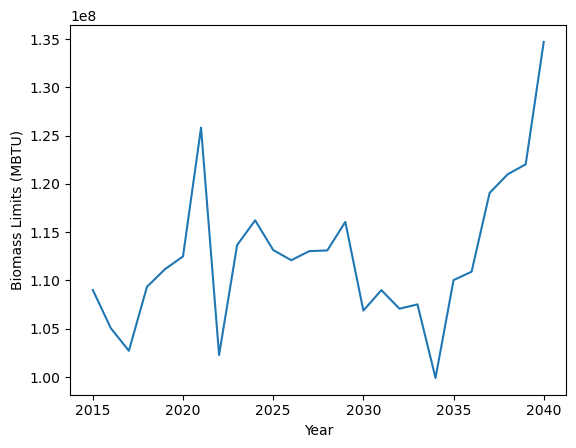

In [357]:
plt.xlabel("Year")
plt.ylabel("Biomass Limits (MBTU)")
plt.plot(SummaryBiomassLimits_df["Year"],SummaryBiomassLimits_df["MBTUs"])

### Landfill Gas

In [358]:
# Assume no substantial change from current values
#EIA 923
#Have to enter the value by hand on the efficiency table


def EstimateLandfill(Path):
    Path=EIA_923_Path
    EIA923_df = pd.read_excel(EIA_923_Path,sheet_name ='Page 1 Generation and Fuel Data',skiprows=5)
    EIA923_State=EIA923_df["Plant State"]
    EIA923_df=EIA923_df[EIA923_State==State]

    EIA923_df=EIA923_df[(EIA923_df["Net Generation\n(Megawatthours)"]>0)] 

    #On EIA 860 combined cycle tech are divided in CT and CA (steam part)
    #We need to combine them as CC: combine cycle
    EIA923_Mover=EIA923_df["Reported\nPrime Mover"]
    EIA923_FuelType=EIA923_df["Reported\nFuel Type Code"]
    EIA923_EnergyGen=EIA923_df["Elec Fuel Consumption\nMMBtu"]

    UniqueMoverFuel = EIA923_df[["Reported\nFuel Type Code","Reported\nPrime Mover"]].drop_duplicates()
    UniqueMoverFuel["MMBTU"]=0

    for Mover, Fuel in zip(UniqueMoverFuel.iloc[:,1],UniqueMoverFuel.iloc[:,0]):
        Idx=(UniqueMoverFuel["Reported\nPrime Mover"]==Mover) * (UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel)
        UniqueMoverFuel.loc[Idx,"MMBTU"]=np.sum(EIA923_EnergyGen[(EIA923_Mover==Mover) * (EIA923_FuelType==Fuel)])

    UniqueMoverFuel=UniqueMoverFuel[UniqueMoverFuel["Reported\nFuel Type Code"]=="LFG"] #LFG is landfill gas
    print("Total LFG MMBTU: ",np.sum(UniqueMoverFuel["MMBTU"]))
    return UniqueMoverFuel

LandFill_df=EstimateLandfill(EIA_923_Path)#2021 Esimate
_=EstimateLandfill(EIA_923_Path_2020)#2020 Esimate

Total LFG MMBTU:  5155952
Total LFG MMBTU:  5155952


### Combine Landfill and other Biomass

In [359]:
TotalBiomassANDLFLimits=SummaryBiomassLimits_df.copy()
TotalBiomassANDLFLimits["MBTUs"]=SummaryBiomassLimits_df["MBTUs"]+np.sum(LandFill_df["MMBTU"])
print("Average Limit For Biomass and Landfill MMBTUs: ",np.mean(TotalBiomassANDLFLimits["MBTUs"]))

#MMBTUs to PJ
print("Average Limit For Biomass and Landfill PJ: ",np.mean(TotalBiomassANDLFLimits["MBTUs"]*1.0550559e-6))

Average Limit For Biomass and Landfill MMBTUs:  117594259.34615384
Average Limit For Biomass and Landfill PJ:  124.06851712928976


## MaxCapacity

### Wind

In [360]:
#Wind
#Offshore Wind Energy- File needs to contain only locations of the desired state and depths and distances from shore you want to consider
OffshoreWindCapacity_Excel=pd.read_csv(SAM_NREL_Path+"WindData_Capacity/Offshore_WindNREL.csv")

LandWindCapacity_Excel=pd.read_csv(SAM_NREL_Path+"WindData_Capacity/LandWind_NREL.csv")
USStates = gpd.read_file(StatesSHP)

#Land Wind Energy
df=LandWindCapacity_Excel[["longitude","latitude"]]
points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

within_points = gpd.sjoin(points, USStates[USStates["stusab"]==State])
IdxIn=within_points.index
LandWindCapacity_Excel_Filtered=LandWindCapacity_Excel.iloc[IdxIn,:]

print("Maxixum Land Wind Capacity %.2f GW" % (LandWindCapacity_Excel_Filtered["capacity_mw"].sum()/1000))
print("Average CF from This db for Land Wind %.2f" % (LandWindCapacity_Excel_Filtered["capacity_factor"].mean()))

print("\nMaxixum Offshore Wind Capacity %.2f GW" % (OffshoreWindCapacity_Excel["capacity_mw"].sum()/1000))
print("Average CF from This db for Offshore Wind %.2f" % (OffshoreWindCapacity_Excel["capacity_factor"].mean()))

#We will not make any bound on wind or solar capacity as the available capacity is much larger than the demand

Maxixum Land Wind Capacity 181.75 GW
Average CF from This db for Land Wind 0.34

Maxixum Offshore Wind Capacity 28.47 GW
Average CF from This db for Offshore Wind 0.42


## Group Technologies and Define MaxCapacityGroup

In [361]:
#build MaxCapacityGroup_sql, TechGroupWeight_sql, groups_sql, tech_groups_sql

Group_Excel=pd.read_excel(UserDataPath+"UserDataPart3.xlsx", sheet_name ='groups')

techOn_groups=Group_Excel.iloc[:,1:].stack().reset_index(drop=True)
techOn_groups=techOn_groups.unique()

tech_groups_sql=pd.DataFrame({"tech":techOn_groups,"notes":""})
groups_sql=pd.DataFrame({"group_name":Group_Excel["Group Name"],"notes":""})
MaxCapacityGroup_sql  = pd.read_excel(UserDataPath+"UserDataPart3.xlsx", sheet_name ='MaxCapacityGroup')


TechGroupWeight_sql=pd.DataFrame(columns=["regions","tech","group_name","weight","tech_desc"])
#TechGroupWeight_sql
for group_id in range(Group_Excel.shape[0]):
    group=Group_Excel.iloc[group_id,0]
    for tech_id in range(Group_Excel.shape[1]-1):
        tech=Group_Excel.iloc[group_id,tech_id+1]
        if isinstance(tech,str)==1:
            #Get all istances of regions for these technologies
            unique_regions=Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"regions"].unique()
            TechGroupWeight_tmp_sql=pd.DataFrame({"regions":unique_regions,"tech":tech,"group_name":group,"weight":1,"tech_desc":""})    

            TechGroupWeight_sql=pd.concat([TechGroupWeight_sql,TechGroupWeight_tmp_sql],ignore_index=True)

                                           

## Carbon Capture Technologies

In [362]:
# Geologic sequestration is not economically or technically feasible within North Carolina (Carbon Capture, Pipeline and Storage:A Viable Option for North Carolina Utilities?)


## Empty or very small dfs: 

In [363]:
#Empty dataframes
CapacityFactorTech_sql=pd.DataFrame(columns=["regions","season_name","time_of_day_name","tech","cf_tech","cf_tech_notes"])
GrowthRateMax_sql=pd.DataFrame(columns=["regions","tech","growthrate_max","growthrate_max_notes"])
GrowthRateSeed_sql=pd.DataFrame(columns=["regions","tech","growthrate_seed","growthrate_seed_units","growthrate_seed_notes"])
LifetimeProcess_sql=pd.DataFrame(columns=["regions","tech","vintage","life_process","life_process_notes"])

tech_new_cluster_sql=pd.DataFrame(columns=["regions","tech","cap_size"])
MinGenGroupTarget_sql=pd.DataFrame(columns=["periods","group_name","min_act_g","notes"])
MinGenGroupWeight_sql=pd.DataFrame(columns=["regions","tech","group_name","act_fraction","tech_desc"])
MyopicBaseyear_sql=pd.DataFrame(columns=["year"])
TechOutputSplit_sql=pd.DataFrame(columns=["regions","periods","tech","output_comm","to_split","to_split_notes"])
time_renewable_sql=pd.DataFrame(columns=["Field1"])
tech_variable_sql=pd.DataFrame(columns=["tech","notes"])
tech_flex_sql=pd.DataFrame(columns=["tech","notes"])
tech_annual_sql=pd.DataFrame(columns=["tech","notes"])
StorageInit_sql=pd.DataFrame(columns=["storage_tech","storage_tech_note"])
tech_ramping_sql=pd.DataFrame(columns=["tech"]) #According to REeds we have a ramping cap above 100%/hr for all technologies. So this term will be ignored
RampDown_sql=pd.DataFrame(columns=["regions","tech","ramp_down"])
RampUp_sql=pd.DataFrame(columns=["regions","tech","ramp_up"])
TechInputSplit_sql=pd.DataFrame(columns=["regions","periods","input_comm","tech","ti_split","ti_split_notes"])
TechInputSplitAverage_sql=pd.DataFrame(columns=["regions","periods","input_comm","tech","ti_split","ti_split_notes"])
LinkedTechs_sql=pd.DataFrame(columns=["primary_region","primary_tech","emis_comm","linked_tech","linked_tech_notes"])

#outputs
Output_CapacityByPeriodAndTech_sql=pd.DataFrame(columns=["regions","scenario","sector","t_periods","tech","capacity"])
Output_Costs_sql=pd.DataFrame(columns=["regions","scenario","sector","output_name","tech","vintage","output_cost"])
Output_Curtailment_sql=pd.DataFrame(columns=["regions","scenario","sector","t_periods","t_season","t_day","input_comm","tech","vintage","output_comm","curtailment"])
Output_Duals_sql=pd.DataFrame(columns=["constraint_name","scenario","dual"])
Output_Emissions_sql=pd.DataFrame(columns=["regions","scenario","sector","t_periods","emissions_comm","tech","vintage","emissions"])
Output_Objective_sql=pd.DataFrame(columns=["scenario","objective_name","total_system_cost"])
Output_VFlow_In_sql=pd.DataFrame(columns=["regions","scenario","sector","t_periods","t_season","t_day","input_comm","tech","vintage","output_comm","vflow_in"])
Output_VFlow_Out_sql=pd.DataFrame(columns=["regions","scenario","sector","t_periods","t_season","t_day","input_comm","tech","vintage","output_comm","vflow_out"])
Output_V_Capacity_sql=pd.DataFrame(columns=["regions","scenario","sector","tech","vintage","capacity"])


#Very simple dataframes
GlobalDiscountRate_sql=pd.DataFrame([0.05],columns=["rate"])
regions_sql=pd.DataFrame({"regions": RegionsDefinition, "region_note":RegionNotes})

#Directly from the excel file
EmissionLimit_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='EmissionLimit')
PlanningReserveMargin_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='PlanningReserveMargin',usecols='A,B')
tech_curtailment_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='tech_curtailment')
MaxResource_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='MaxResource')

MaxCapacity_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='MaxCapacity')
MinCapacity_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='MinCapacity')
MaxActivity_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='MaxActivity')
MinActivity_sql  = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='MinActivity')



In [364]:
#For df coming directly from excel remove years not in the model
MaxCapacityGroup_sql=MaxCapacityGroup_sql[MaxCapacityGroup_sql["periods"].isin(FutureYears[0:-1])]
EmissionLimit_sql=EmissionLimit_sql[EmissionLimit_sql["periods"].isin(FutureYears[0:-1])]
MaxActivity_sql=MaxActivity_sql[MaxActivity_sql["periods"].isin(FutureYears[0:-1])]

# Ajust time_of_day

In [365]:
#Control the number of hours in the day to reduce memory usage

#if NumHoursAjust!=24:
time_of_day_sql=pd.DataFrame({"t_day":list(NumHoursAjust.keys())})
SegFrac_sql_old=SegFrac_sql.copy(deep=True)
SegFrac_sql=pd.DataFrame(columns=["season_name","time_of_day_name","segfrac","segfrac_notes"])

DemandSpecificDistribution_sql_old=DemandSpecificDistribution_sql.copy(deep=True)
DemandSpecificDistribution_sql=pd.DataFrame(columns=DemandSpecificDistribution_sql_old.columns)

CapacityFactorProcess_sql_old=CapacityFactorProcess_sql.copy(deep=True)
CapacityFactorProcess_sql=pd.DataFrame(columns=CapacityFactorProcess_sql_old.columns)

DataSegFrac_sql=[]

for time_name in list(NumHoursAjust.keys()):
    TimesToAggregate=NumHoursAjust[time_name]

# SegFrac_sql
    for s in SegFrac_sql_old["season_name"].unique():
        new_frac=SegFrac_sql_old[(SegFrac_sql_old["season_name"]==s)*([t in TimesToAggregate for t in SegFrac_sql_old["time_of_day_name"]])]["segfrac"].sum()
        DataSegFrac_sql.append([s,time_name,new_frac,""])

#DemandSpecificDistribution_sql
    Dsd_tmp=DemandSpecificDistribution_sql_old[[t in TimesToAggregate for t in DemandSpecificDistribution_sql_old["time_of_day_name"]]].groupby(["regions","season_name","demand_name"])["dds"].sum().reset_index()
    Dsd_tmp["time_of_day_name"]=time_name
    Dsd_tmp["dds_notes"]=DemandSpecificDistribution_sql_old[[t in TimesToAggregate for t in DemandSpecificDistribution_sql_old["time_of_day_name"]]]["dds_notes"].values[0]
    DemandSpecificDistribution_sql=pd.concat([DemandSpecificDistribution_sql,Dsd_tmp],ignore_index=True)
   
    #CapacityFactorTech_sql (not used in the model)

    #CapacityFactorProcess_sql
    CFP_tmp=CapacityFactorProcess_sql_old[[t in TimesToAggregate for t in CapacityFactorProcess_sql_old["time_of_day_name"]]].groupby(["regions","season_name","tech","vintage"])["cf_process"].mean().reset_index()
    CFP_tmp["time_of_day_name"]=time_name
    CapacityFactorProcess_sql=pd.concat([CapacityFactorProcess_sql,CFP_tmp],ignore_index=True)

SegFrac_sql=pd.DataFrame(DataSegFrac_sql,columns=["season_name","time_of_day_name","segfrac","segfrac_notes"]).sort_values(["season_name","time_of_day_name"]).reset_index(drop=True)

# Adjust Variables for Numerical Stability

In [366]:
#round values to ensure numerical stability
CapacityCredit_sql["cf_tech"]=round(CapacityCredit_sql["cf_tech"],3)
CapacityFactorProcess_sql["cf_process"]=round(CapacityFactorProcess_sql["cf_process"],3)
CapacityFactorTech_sql["cf_tech"]=round(CapacityFactorTech_sql["cf_tech"],3)
CapacityToActivity_sql["c2a"]=round(CapacityToActivity_sql["c2a"],3)
CostFixed_sql["cost_fixed"]=round(CostFixed_sql["cost_fixed"],3)
CostInvest_sql["cost_invest"]=round(CostInvest_sql["cost_invest"],3)
CostVariable_sql["cost_variable"]=round(CostVariable_sql["cost_variable"],3)
Demand_sql["demand"]=round(Demand_sql["demand"],4)
DemandSpecificDistribution_sql["dds"]=round(DemandSpecificDistribution_sql["dds"],6)
DiscountRate_sql["tech_rate"]=round(DiscountRate_sql["tech_rate"],3)
Efficiency_sql["efficiency"]=Efficiency_sql["efficiency"].astype(float).round(3)
EmissionActivity_sql["emis_act"]=EmissionActivity_sql["emis_act"].astype(float).round(3)
EmissionLimit_sql["emis_limit"]=EmissionLimit_sql["emis_limit"].astype(float).round(3)
ExistingCapacity_sql["exist_cap"]=ExistingCapacity_sql["exist_cap"].astype(float).round(4)
GlobalDiscountRate_sql["rate"]=GlobalDiscountRate_sql["rate"].astype(float).round(3)
GrowthRateMax_sql["growthrate_max"]=GrowthRateMax_sql["growthrate_max"].astype(float).round(4)
GrowthRateSeed_sql["growthrate_seed"]=GrowthRateSeed_sql["growthrate_seed"].astype(float).round(4)
MaxActivity_sql["maxact"]=MaxActivity_sql["maxact"].astype(float).round(4)
MaxCapacity_sql["maxcap"]=MaxCapacity_sql["maxcap"].astype(float).round(4)
MaxResource_sql["maxres"]=MaxResource_sql["maxres"].astype(float).round(4)
MinActivity_sql["minact"]=MinActivity_sql["minact"].astype(float).round(4)
MinCapacity_sql["mincap"]=MinCapacity_sql["mincap"].astype(float).round(4)
PlanningReserveMargin_sql["reserve_margin"]=PlanningReserveMargin_sql["reserve_margin"].astype(float).round(3)
#SegFrac_sql["segfrac"]=SegFrac_sql["segfrac"].astype(float).round(6)
MaxCapacityGroup_sql["max_cap_g"]=MaxCapacityGroup_sql["max_cap_g"].astype(float).round(4)

# Create sql and sqlite files

In [367]:
DicOfDfs={
"CapacityCredit":CapacityCredit_sql,
"CapacityFactorProcess":CapacityFactorProcess_sql,
"CapacityFactorTech":CapacityFactorTech_sql,
"CapacityToActivity":CapacityToActivity_sql,
"CostFixed":CostFixed_sql,
"CostInvest":CostInvest_sql,
"CostVariable":CostVariable_sql,
"Demand":Demand_sql, 
"DemandSpecificDistribution":DemandSpecificDistribution_sql,
"DiscountRate":DiscountRate_sql,
"Efficiency":Efficiency_sql,
"EmissionActivity":EmissionActivity_sql,
"EmissionLimit":EmissionLimit_sql,
"ExistingCapacity":ExistingCapacity_sql,
"GlobalDiscountRate":GlobalDiscountRate_sql,
"GrowthRateMax":GrowthRateMax_sql,
"GrowthRateSeed":GrowthRateSeed_sql,
"LifetimeLoanTech":LifetimeLoanTech_sql,
"LifetimeProcess":LifetimeProcess_sql,
"LifetimeTech":LifetimeTech_sql,
"LinkedTechs":LinkedTechs_sql,
"MaxActivity":MaxActivity_sql,
"MaxCapacity":MaxCapacity_sql,
"MaxResource":MaxResource_sql,
"MinActivity":MinActivity_sql,
"MinCapacity":MinCapacity_sql,
"MinGenGroupTarget":MinGenGroupTarget_sql,
"MinGenGroupWeight":MinGenGroupWeight_sql,
"MyopicBaseyear":MyopicBaseyear_sql,
"Output_CapacityByPeriodAndTech":Output_CapacityByPeriodAndTech_sql,
"Output_Costs":Output_Costs_sql,
"Output_Curtailment":Output_Curtailment_sql,
"Output_Duals":Output_Duals_sql,
"Output_Emissions":Output_Emissions_sql,
"Output_Objective":Output_Objective_sql,
"Output_VFlow_In":Output_VFlow_In_sql,
"Output_VFlow_Out":Output_VFlow_Out_sql,
"Output_V_Capacity":Output_V_Capacity_sql,
"PlanningReserveMargin":PlanningReserveMargin_sql,
"RampDown":RampDown_sql,
"RampUp":RampUp_sql,
"SegFrac":SegFrac_sql,
"StorageDuration":StorageDuration_sql,
"StorageInit":StorageInit_sql,
"TechInputSplit":TechInputSplit_sql,
"TechInputSplitAverage":TechInputSplitAverage_sql,
 "TechOutputSplit":TechOutputSplit_sql,
"commodities":commodities_sql,
"commodity_labels":commodity_labels_sql,
"groups":groups_sql,
"regions":regions_sql,
"sector_labels":sector_labels_sql,
"tech_annual":tech_annual_sql,
"tech_curtailment":tech_curtailment_sql,
"tech_exchange":tech_exchange_sql,
"tech_flex":tech_flex_sql,
"tech_groups":tech_groups_sql,
"tech_new_cluster":tech_new_cluster_sql,
"tech_ramping":tech_ramping_sql,
"tech_reserve":tech_reserve_sql,
"tech_variable":tech_variable_sql,
"technologies":technologies_sql,
"technology_labels":technology_labels_sql,
"time_of_day":time_of_day_sql,
"time_period_labels":time_period_labels_sql,
"time_periods":time_periods_sql,
"time_renewable":time_renewable_sql,
"time_season":time_season_sql,
"MaxCapacityGroup": MaxCapacityGroup_sql, 
"TechGroupWeight":TechGroupWeight_sql}

In [368]:
try:
    os.remove("OutputData/"+SaveSqlName+".sqlite")
except:
    pass

!sqlite3 OutputData/ReferenceSql.sqlite < InputData/ReferenceSql.sql
os.rename("OutputData/ReferenceSql.sqlite", "./OutputData/"+SaveSqlName+".sqlite")

#Insert data
engine = create_engine('sqlite:///'+"OutputData/"+SaveSqlName+".sqlite", echo=False)
NamesDic=list(DicOfDfs.keys())
for i in range(len(NamesDic)):
    DicOfDfs[NamesDic[i]]=DicOfDfs[NamesDic[i]].reset_index(drop=True) #remove index
    DicOfDfs[NamesDic[i]].to_sql(NamesDic[i], con=engine, if_exists='append', index=False)
    print(NamesDic[i]+" saved")

con = sqlite3.connect("OutputData/"+SaveSqlName+".sqlite")
with open("OutputData/"+SaveSqlName+".sql", 'w') as f:
    for line in con.iterdump():
        f.write('%s\n' % line)
con.close()
# engine.dispose(close=True)

CapacityCredit saved
CapacityFactorProcess saved
CapacityFactorTech saved
CapacityToActivity saved
CostFixed saved
CostInvest saved
CostVariable saved
Demand saved
DemandSpecificDistribution saved
DiscountRate saved
Efficiency saved
EmissionActivity saved
EmissionLimit saved
ExistingCapacity saved
GlobalDiscountRate saved
GrowthRateMax saved
GrowthRateSeed saved
LifetimeLoanTech saved
LifetimeProcess saved
LifetimeTech saved
LinkedTechs saved
MaxActivity saved
MaxCapacity saved
MaxResource saved
MinActivity saved
MinCapacity saved
MinGenGroupTarget saved
MinGenGroupWeight saved
MyopicBaseyear saved
Output_CapacityByPeriodAndTech saved
Output_Costs saved
Output_Curtailment saved
Output_Duals saved
Output_Emissions saved
Output_Objective saved
Output_VFlow_In saved
Output_VFlow_Out saved
Output_V_Capacity saved
PlanningReserveMargin saved
RampDown saved
RampUp saved
SegFrac saved
StorageDuration saved
StorageInit saved
TechInputSplit saved
TechInputSplitAverage saved
TechOutputSplit save

# Save hurricane speed statistics and damage for each technology/region

## Get Speed data from Hazus

### Prepare Dataframe

In [369]:
df_ExistingGeneratorData=df_AggregateGen.copy()
df_ExistingGeneratorData.drop(columns=["NetSummerCapacity(MW)","NetWinterCapacity(MW)","Technology"],inplace=True)
df_ExistingGeneratorData["tech"]=""

for i in range(len(df_ExistingGeneratorData)):
    if df_ExistingGeneratorData.loc[i,"MoverCode"]!="BA":
        df_ExistingGeneratorData.loc[i,"tech"]=df_ExistingGeneratorData.loc[i,"SourceCode"]+"_"+df_ExistingGeneratorData.loc[i,"MoverCode"]+"_EXISTING"
    else:
        HoursOfOperation=df_ExistingGeneratorData.loc[i,"NameplateEnergyCapacity(MWh)"]/df_ExistingGeneratorData.loc[i,"NameplateCapacity(MW)"] #h operation of each battery
        TmpBrack_L=np.array([0, 1, 2 ,4, 6, 8 ])
        TmpBrack_U=np.array([1, 2 ,4, 6, 8 ,10])
        
        IdxInBatteryH=(HoursOfOperation>TmpBrack_L) * (HoursOfOperation<=TmpBrack_U)
        h_battery=TmpBrack_U[IdxInBatteryH][0]
        if sum(IdxInBatteryH)!=0:
            df_ExistingGeneratorData.loc[i,"NameplateCapacity(MW)"]=df_ExistingGeneratorData.loc[i,"NameplateEnergyCapacity(MWh)"]/h_battery #MW
            df_ExistingGeneratorData.loc[i,"tech"]=df_ExistingGeneratorData.loc[i,"SourceCode"]+"_"+df_ExistingGeneratorData.loc[i,"MoverCode"]+str(h_battery)+"H_EXISTING"

df_ExistingGeneratorData.drop(columns=["NameplateEnergyCapacity(MWh)"],inplace=True)


### Existing Generators

In [370]:
#df_AggregateGen: Contains information about existing generation location (lat, long and region) and capacity
#Assign a HAZUS region to existing each generator
ExistingGenLatLong=[Point(df_ExistingGeneratorData.at[i,"Longitude"],df_ExistingGeneratorData.at[i,"Latitude"]) for i in range(len(df_ExistingGeneratorData))]
IdxGenerator2Hazus=[]

for i in tqdm(range(len(ExistingGenLatLong))):

    flag=0
    for p in range (len(shapefile_Hazus)):
        
        if shapefile_Hazus.iloc[p].geometry.contains(ExistingGenLatLong[i]):
            IdxGenerator2Hazus.append(p)
            flag=1

    if flag==0:
        IdxGenerator2Hazus.append(-1) #if no match found, append -1

if sum(np.array(IdxGenerator2Hazus)==-1)>0:
    print("Warning: "+str(sum(np.array(IdxGenerator2Hazus)==-1))+" generators are not located in the region of interest")
    sys.exit()


for new_column in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]:   
    df_ExistingGeneratorData[new_column]=shapefile_Hazus.loc[IdxGenerator2Hazus,new_column].reset_index(drop=True)

  0%|          | 0/945 [00:00<?, ?it/s]

100%|██████████| 945/945 [02:11<00:00,  7.20it/s]


### Future Generators

In [371]:
df_FutureGenerators=CostInvest_sql.groupby(["regions","tech"]).size().reset_index().rename(columns={0:'Occurances'}) 
df_FutureGenerators=df_FutureGenerators.drop(columns=["Occurances"])
df_FutureGenerators=df_FutureGenerators.reset_index(drop=True)

WindSpeed_df={"R1": Region1Data, "R2": Region2Data, "R3": Region3Data}

for new_column in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]:   
    df_FutureGenerators[new_column]=-1
    df_FutureGenerators[new_column]=df_FutureGenerators[new_column].astype(object)
    for region in RegionsDefinition:
        WS=np.array(WindSpeed_df[region][new_column])

        IdxIn=df_FutureGenerators["regions"]==region
        for i in np.where(IdxIn)[0]:
            df_FutureGenerators.at[i, new_column] = pd.Series(WS)
        
#Update Technologies With specific locations
ExcelLocations=pd.read_excel(FragilityCurvesDataPath+"SpecialLocationFutureTech.xlsx")

#Centroids of Hazus regions
CenLong=shapefile_Hazus.CenLongit
CenLat=shapefile_Hazus.CenLat

for row in ExcelLocations.iterrows():
    region=row[1]["Region"]
    tech=row[1]["Tech"]
    
    Location=row[1]["Location"]
    Location=Location.replace('(', '')
    Location=Location.replace(')', '')

    if Location.find('+')!=-1:
        WS=[]
        for Concat_region in Location.split('+'):  
            #Concatenate speeds of two regions
            WS=WS+list(WindSpeed_df[Concat_region][new_column])

        IdxIn=(df_FutureGenerators["regions"]==region)*(df_FutureGenerators["tech"]==tech)
        for i in np.where(IdxIn)[0]:

            for new_column in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]: 
                df_FutureGenerators.at[i, new_column] = pd.Series(np.array(WS))

    else:#Add a series of wind speed from each point reported in the excel file
        Location=Location.split(';')
        PointsLoc=[[float(Location[i].split(',')[1]),float(Location[i].split(',')[0])] for i in range(len(Location))]

        IdxIn=(df_FutureGenerators["regions"]==region)*(df_FutureGenerators["tech"]==tech)
        IdxIn=IdxIn.where(IdxIn==True).dropna().index[0]

        for new_column in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]: 
            WS=[]
            for LongLat in PointsLoc:
                PointLong=LongLat[0]
                PointLat=LongLat[1]
                IdxClosestRegion=np.argmin(np.sqrt((CenLong-PointLong)**2+(CenLat-PointLat)**2))
                WS.append(shapefile_Hazus.iloc[IdxClosestRegion][new_column])

            df_FutureGenerators.at[IdxIn, new_column] = pd.Series(np.array(WS))


## Assign Probability of Damage

In [372]:
# For existing generators is the weighted average (by capacity) of the all technologies in the region
# For future generators is the mean of damage caused by all wind speeds assigned to the technology in the region
TechFragilityName=pd.read_excel(FragilityCurvesDataPath+"Tech2FragilityCurve.xlsx")

PercentageHurricaneDamage=pd.DataFrame(columns=["regions","tech","f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"])

SkeletonOfRegionsandTech=Efficiency_sql.groupby(["regions","tech"]).size().reset_index().rename(columns={0:'Occurances'}) 
SkeletonOfRegionsandTech=SkeletonOfRegionsandTech.drop(columns=["Occurances"])

PercentageHurricaneDamage["regions"]=SkeletonOfRegionsandTech["regions"]
PercentageHurricaneDamage["tech"]=SkeletonOfRegionsandTech["tech"]

#existing generators
for tech in df_ExistingGeneratorData["tech"].unique():
    FCName=TechFragilityName.loc[TechFragilityName["Technologies"]==tech,"Fragility Curve Name"].values[0] #name of the fragility curve
    IdxIn=df_ExistingGeneratorData["tech"]==tech

    #Get all generators with the same tech name in the same region
    for region in df_ExistingGeneratorData.loc[IdxIn,"Region"].unique():
        IdxIn2=(df_ExistingGeneratorData["tech"]==tech)*(df_ExistingGeneratorData["Region"]==region)
        df_temp=df_ExistingGeneratorData.loc[IdxIn2,:]

        IdxInProb_df=(PercentageHurricaneDamage["tech"]==tech)*(PercentageHurricaneDamage["regions"]==region)
        for recurrency in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]:
            P_damage_eachCapacity=fragility(df_temp[recurrency].values,FCName)
            WeightedAverage=np.sum(P_damage_eachCapacity*df_temp["NameplateCapacity(MW)"].values)/np.sum(df_temp["NameplateCapacity(MW)"].values)
            PercentageHurricaneDamage.loc[IdxInProb_df,recurrency]=WeightedAverage
            
#future generators
for row in df_FutureGenerators.iterrows():
    region=row[1]["regions"]
    tech=row[1]["tech"]
    FCName=TechFragilityName.loc[TechFragilityName["Technologies"]==tech,"Fragility Curve Name"].values[0] #name of the fragility curve

    IdxInProb_df=(PercentageHurricaneDamage["tech"]==tech)*(PercentageHurricaneDamage["regions"]==region)
    for recurrency in ["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]:
        WSpeed=row[1][recurrency]
        AverageDamage=np.average(fragility(WSpeed,FCName))
        PercentageHurricaneDamage.loc[IdxInProb_df,recurrency]=AverageDamage



#PercentageHurricaneDamage.to_excel(FragilityCurvesDataPath+"PercentageHurricaneDamage.xlsx",index=False)


Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC
Invalid fragility curve type:Victor_OC


## Assign damage to appropriate periods

In [373]:
#Scenarios were defined at the beginning of the script
Scenarios

{'S0': {'Name': 'Low/No Impact Hurricane',
  'HazusCodes': ['f10yr', 'f20yr'],
  'ProbPerYear': '1-S1-S2'},
 'S1': {'Name': 'Medium Impact Hurricane',
  'HazusCodes': ['f100yr', 'f50yr'],
  'ProbPerYear': 0.03},
 'S2': {'Name': 'High Impact Hurricane',
  'HazusCodes': ['f200yr', 'f500yr', 'f1000yr'],
  'ProbPerYear': 0.008}}

In [374]:
prob=np.array([1/10, 1/20, 1/50, 1/100, 1/200, 1/500, 1/1000])
prob_tags=["f10yr","f20yr","f50yr","f100yr","f200yr","f500yr","f1000yr"]

for i_scenario in list(Scenarios.keys()):
    PercentageHurricaneDamage[i_scenario]=-1
    HazusCodes=Scenarios[i_scenario]["HazusCodes"]
    Idx=[prob_tags.index(HazusCodes[i]) for i in range(len(HazusCodes))]
    df_tmp=PercentageHurricaneDamage.iloc[:,2:9]*prob
    df_tmp=df_tmp.iloc[:,Idx]
    DenominatorProb=np.sum(prob[Idx])

    if i_scenario!="S0":
        PercentageHurricaneDamage.loc[:, i_scenario]=np.sum(df_tmp,axis=1)/DenominatorProb

    if i_scenario=="S0":
        DenominatorProb=1-sum([Scenarios[i_scenario]["ProbPerYear"] for i_scenario in list(Scenarios.keys())[1:]]) #probability of not having any hurricane or very low impact hurricane
        PercentageHurricaneDamage.loc[:, i_scenario]=np.sum(df_tmp,axis=1)/DenominatorProb

In [375]:
for l in list(PercentageHurricaneDamage.columns[2:]):#round to 4 decimals
    PercentageHurricaneDamage[l]=PercentageHurricaneDamage[l].astype(float).round(4)


In [376]:
# Probability of each scenario
NumYearsEachPeriod=np.array(FutureYears[1:])-np.array(FutureYears[:-1])
YearsOptimization=FutureYears[:-1]
scenarios_name=list(Scenarios.keys())
ProbScenario=pd.DataFrame(columns=["t_periods"]+scenarios_name)
ProbScenario["t_periods"]=YearsOptimization


for i in range(len(YearsOptimization)):
    for s in scenarios_name:
        if s!="S0":
            ProbScenario.at[i,s]=Scenarios[s]["ProbPerYear"]*NumYearsEachPeriod[i]

ProbScenario["S0"]=1
for s in scenarios_name:
    if s!="S0":
        ProbScenario["S0"]=ProbScenario["S0"]-ProbScenario[s] 
        

In [377]:
PercentageHurricaneDamage.to_excel(FragilityCurvesDataPath+"PercentageHurricaneDamage.xlsx",index=False)
ProbScenario.to_excel(FragilityCurvesDataPath+"ProbabilityEachScenario.xlsx",index=False)

PercentageHurricaneDamage.to_excel("./OutputData/PercentageHurricaneDamage.xlsx",index=False)
ProbScenario.to_excel("./OutputData/ProbabilityEachScenario.xlsx",index=False)